# Importing Libaries

In [23]:
!pip install mahotas

In [24]:
import cv2 as cv
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np 
from scipy.stats import skew, kurtosis
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy
from skimage import segmentation
from skimage.feature import local_binary_pattern
from skimage.feature import graycomatrix, graycoprops
import mahotas
import pywt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from skimage.feature import hog
from typing import Tuple, List

# Dataset Loading and EDA

In [25]:
# Define classes and the directory where files were extracted
classes = ['nevus', 'others']
image_dir_train = '/kaggle/input/skin-cancer-detecttion/train'

# Initialize an empty list to store image file paths and their corresponding labels
data = []

# Loop through each class folder and each image within that folder
for c in classes:
    class_dir = os.path.join(image_dir_train, c)
    
    if os.path.exists(class_dir):
        for filename in os.listdir(class_dir):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filter image files
                image_path = os.path.join(class_dir, filename)
                data.append([image_path, c])  # Append image path and its label (class)

# Create a pandas DataFrame from the data
df_train = pd.DataFrame(data, columns=['image_path', 'label'])

In [26]:
# Display the first few rows of the DataFrame
df_train.shape

(15195, 2)

In [27]:
image_dir_valid = '/kaggle/input/skin-cancer-detecttion/val'

# Initialize an empty list to store image file paths and their corresponding labels
data = []

# Loop through each class folder and each image within that folder
for c in classes:
    class_dir = os.path.join(image_dir_valid, c)
    
    if os.path.exists(class_dir):
        for filename in os.listdir(class_dir):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filter image files
                image_path = os.path.join(class_dir, filename)
                data.append([image_path, c])  # Append image path and its label (class)

# Create a pandas DataFrame from the data
df_valid = pd.DataFrame(data, columns=['image_path', 'label'])

In [28]:
# Display the first few rows of the DataFrame
df_valid.shape

(3796, 2)

In [29]:
image_dir_test = '/kaggle/input/skin-cancer-detecttion/testX'

# Initialize an empty list to store image file paths and their corresponding labels
data = []
filenames = []

for filename in os.listdir(image_dir_test):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filter image files
        image_path = os.path.join(image_dir_test, filename)
        data.append(image_path)  # Append image path and its label (class)
        filenames.append(filename)

# Create a pandas DataFrame from the data
df_test = pd.DataFrame(list(zip(data, filenames)), columns=['image_path', 'filenames'])

In [30]:
df_test.head()

image_path     filenames
0  /kaggle/input/skin-cancer-detecttion/testX/xxx...  xxx02954.jpg
1  /kaggle/input/skin-cancer-detecttion/testX/xxx...  xxx02478.jpg
2  /kaggle/input/skin-cancer-detecttion/testX/xxx...  xxx03120.jpg
3  /kaggle/input/skin-cancer-detecttion/testX/xxx...  xxx01446.jpg
4  /kaggle/input/skin-cancer-detecttion/testX/xxx...  xxx05189.jpg

In [31]:
print(df_test['image_path'][0])
print(df_test['filenames'][0])

/kaggle/input/skin-cancer-detecttion/testX/xxx02954.jpg
xxx02954.jpg


In [32]:
# Save the DataFrame as a CSV file
df_test['filenames'].to_csv('binary_test_filenames.csv', index=False)

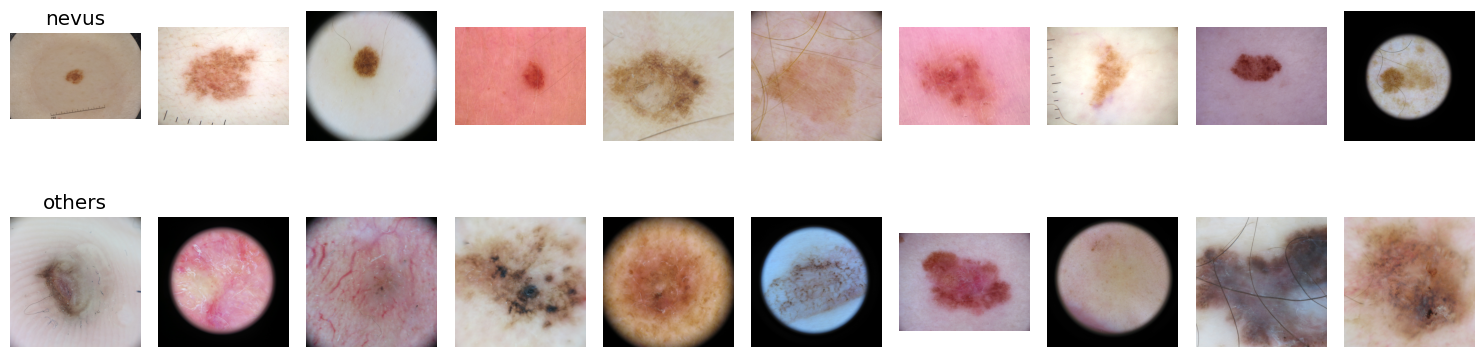

In [33]:
# Number of random images to select per class
num_images = 10

# Initialize a dictionary to store selected image paths by class
selected_images = {}

# Loop through each class and randomly sample 10 images
for c in df_train['label'].unique():
    class_images = df_train[df_train['label'] == c]  # Filter DataFrame by class
    sampled_images = class_images.sample(n=min(len(class_images), num_images))  # Randomly sample 10 images
    selected_images[c] = sampled_images['image_path'].tolist()

# Plot the randomly selected images
fig, axes = plt.subplots(len(selected_images), num_images, figsize=(15, 5))

for class_idx, c in enumerate(selected_images.keys()):
    for img_idx, img_path in enumerate(selected_images[c]):
        img = cv.imread(img_path)
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
        ax = axes[class_idx, img_idx]
        ax.imshow(img_rgb)
        ax.axis('off')  # Hide axis for cleaner display
        if img_idx == 0:
            ax.set_title(c)  # Set class label as title on the first image of each row

plt.tight_layout()
plt.show()

In [34]:
selected_images

{'nevus': ['/kaggle/input/skin-cancer-detecttion/train/nevus/nev02034.jpg',
  '/kaggle/input/skin-cancer-detecttion/train/nevus/nev05079.jpg',
  '/kaggle/input/skin-cancer-detecttion/train/nevus/nev01226.jpg',
  '/kaggle/input/skin-cancer-detecttion/train/nevus/nev02256.jpg',
  '/kaggle/input/skin-cancer-detecttion/train/nevus/nev00696.jpg',
  '/kaggle/input/skin-cancer-detecttion/train/nevus/nev00630.jpg',
  '/kaggle/input/skin-cancer-detecttion/train/nevus/nev04272.jpg',
  '/kaggle/input/skin-cancer-detecttion/train/nevus/nev06137.jpg',
  '/kaggle/input/skin-cancer-detecttion/train/nevus/nev05390.jpg',
  '/kaggle/input/skin-cancer-detecttion/train/nevus/nev07616.jpg'],
 'others': ['/kaggle/input/skin-cancer-detecttion/train/others/mel01245.jpg',
  '/kaggle/input/skin-cancer-detecttion/train/others/ack00380.jpg',
  '/kaggle/input/skin-cancer-detecttion/train/others/bcc00951.jpg',
  '/kaggle/input/skin-cancer-detecttion/train/others/mel02698.jpg',
  '/kaggle/input/skin-cancer-detecttio

# Preprocessing 

In [35]:
# def _roi(self, img, threshold=50):
#         """
#         Extract the region of interest (ROI) from the image based on a 2D analysis of pixel intensity values.

#         Parameters:
#             img (numpy.ndarray): Input image.
#             threshold (int): Threshold value to determine the cropping boundaries.

#         Returns:
#             numpy.ndarray: Cropped image containing the ROI.
#         """
#         # Convert the image to grayscale to simplify intensity calculations
#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#         # Calculate mean values along rows and columns
#         row_means = np.mean(gray, axis=1)
#         col_means = np.mean(gray, axis=0)

#         # Find the start and end points where the mean value exceeds the threshold for rows and columns
#         y_above_threshold = np.where(row_means >= threshold)[0]
#         x_above_threshold = np.where(col_means >= threshold)[0]

#         # If no values exceed the threshold, return the original image
#         if y_above_threshold.size == 0 or x_above_threshold.size == 0:
#             return img

#         # Determine the cropping boundaries based on the threshold-crossing points
#         y1, y2 = y_above_threshold[0], y_above_threshold[-1]
#         x1, x2 = x_above_threshold[0], x_above_threshold[-1]

#         # Add padding to preserve context around the region of interest
#         padding = 10  # You can adjust this value
#         y1 = max(0, y1 - padding)
#         y2 = min(img.shape[0], y2 + padding)
#         x1 = max(0, x1 - padding)
#         x2 = min(img.shape[1], x2 + padding)

#         # Crop the image using the calculated coordinates
#         img_new = img[y1:y2, x1:x2, :]

#         # Ensure the cropped image is not empty
#         if img_new.shape[0] == 0 or img_new.shape[1] == 0:
#             return img

#         return img_new

In [36]:
# Preprocessing Class
class Preprocessing:
    """
       Preprocessing class. This class's purpose is to preprocess the images in the dataset.
    """

    def _hair_removal(self, img, se_width=11, se_height=1, n_orientations=8):
        # Input validation for structuring element dimensions
        if se_width % 2 == 0:
            raise ValueError(f"Structuring element width ({se_width}) must be odd")
        if se_height % 2 == 0:
            raise ValueError(f"Structuring element height ({se_height}) must be odd")

        # Convert the original image to grayscale if it has more than 1 channel
        if len(img.shape) == 3:
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        else:
            img_gray = img

        # Create tilted structuring elements
        base = np.zeros((se_width, se_width), dtype=np.uint8)
        for k in range(se_width // 2 - se_height // 2, se_width // 2 + se_height // 2 + 1):
            cv.line(base, (0, k), (se_width, k), 255)

        # Compute rotated structuring elements
        SEs = [base]
        angle_step = 180.0 / n_orientations
        for k in range(1, n_orientations):
            rotation_matrix = cv.getRotationMatrix2D((se_width / 2.0, se_width / 2.0), k * angle_step, 1.0)
            SE = cv.warpAffine(base, rotation_matrix, (se_width, se_width), flags=cv.INTER_NEAREST)
            SEs.append(SE)

        # Initialize sum of blackhat results
        sum_blackhats = np.zeros_like(img_gray, dtype=np.uint16)

        # Apply blackhat operation using each structuring element and accumulate results
        for SE in SEs:
            blackhat = cv.morphologyEx(img_gray, cv.MORPH_BLACKHAT, SE)
            sum_blackhats += blackhat

        # Normalize the sum of blackhats to the range 0-255 and convert to uint8
        cv.normalize(sum_blackhats, sum_blackhats, 0, 255, cv.NORM_MINMAX)
        sum_blackhats = sum_blackhats.astype(np.uint8)

        # Threshold the blackhat sum to create a binary mask for inpainting
        _, thresholded = cv.threshold(sum_blackhats, 0, 255, cv.THRESH_BINARY | cv.THRESH_TRIANGLE)

        # Refine the mask using morphological opening to remove small components
        thresholded = cv.morphologyEx(thresholded, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3)))

        # Dilate the mask slightly to cover the hair regions more effectively
        thresholded = cv.dilate(thresholded, cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5)))

        # Inpaint the original image using the created mask
        if len(img.shape) == 3:
            result = cv.inpaint(img, thresholded, 3, cv.INPAINT_NS)
        else:
            result = cv.inpaint(img_gray, thresholded, 3, cv.INPAINT_NS)

        return result
    
    def _color_constancy(self, img, power=5, gamma=1.4):
        """
        Apply color constancy to the input image using a power transformation and optional gamma correction.

        Parameters:
            img (numpy.ndarray): Input image.
            power (float): Power to use for the power transformation (default is 6).
            gamma (float, optional): Gamma value for gamma correction (default is 2.2).

        Returns:
            numpy.ndarray: Image with color constancy applied.
        """
        # Get the data type of the input image
        img_dtype = img.dtype

        # Apply gamma correction if gamma is provided
        if gamma is not None:
            img = img / 255.0  # Normalize to 0-1
            img = np.power(img, 1 / gamma)
            img = (img * 255).astype('float32')

        # Convert the image to float32 data type for further processing
        img = img.astype('float32')

        # Apply power transformation to the image
        img_power = np.power(img, power)

        # Calculate the mean of img_power along channels (0 and 1)
        rgb_vec = np.power(np.mean(img_power, axis=(0, 1)), 1 / power)

        # Calculate the L2 norm of rgb_vec
        rgb_norm = np.linalg.norm(rgb_vec)

        # Normalize rgb_vec to have unit length
        rgb_vec /= (rgb_norm + 1e-6)  # Added small value to avoid division by zero

        # Scale down rgb_vec to prevent overexposure (tuning parameter)
        scale_factor = 0.8  # Scale down the effect of rgb_vec
        rgb_vec = (1 / (rgb_vec * np.sqrt(3))) * scale_factor

        # Scale img using the adjusted color constancy vector
        img = img * rgb_vec
        img = np.clip(img, 0, 255)

        # Normalize the image to 0-255 if needed
        img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX)

        return img.astype(img_dtype)

    
    def _roi(self, img, threshold=50):
        # Image dimensions
        h, w = img.shape[:2]
        
        # Get the minimum dimension to avoid index errors
        min_dim = min(h, w)
        
        # Calculate mean values along the diagonal
        diagonal_values = np.mean(img[np.arange(min_dim), np.arange(min_dim), :], axis=1)

        # Find the first and last points where the threshold is crossed
        above_threshold = np.where(diagonal_values >= threshold)[0]
        if above_threshold.size == 0:
            # If no diagonal value exceeds the threshold, return the original image
            return img
        
        first_cross = above_threshold[0]
        last_cross = above_threshold[-1]
        
        # Set the coordinates to crop the image
        y1 = max(0, first_cross)
        y2 = min(h, last_cross + 1)
        x1 = max(0, first_cross)
        x2 = min(w, last_cross + 1)
        
        # Crop the image using the calculated coordinates
        img_new = img[y1:y2, x1:x2, :]
        
        # Ensure the cropped image is not empty
        if img_new.shape[0] == 0 or img_new.shape[1] == 0:
            return img

        return img_new
    

    def pad_image(self, img, padding_size):
        # Get the dimensions of the original image
        height_original, width_original = img.shape

        # Create a new larger image with black padding
        new_height = height_original + 2 * padding_size
        new_width = width_original + 2 * padding_size
        padding_image = np.zeros((new_height, new_width), dtype=np.uint8)

        # Calculate the position to place the original image in the center of the new image
        x_offset = padding_size
        y_offset = padding_size

        # Copy the original image into the center of the new image
        padding_image[y_offset:y_offset + height_original, x_offset:x_offset + width_original] = img

        return padding_image, height_original, width_original

    def _back_original_shape(self, eroded_mask, width_original, height_original, padding_size):
        # Back to the original shape
        crop_x_start = padding_size
        crop_x_end = padding_size + width_original
        crop_y_start = padding_size
        crop_y_end = padding_size + height_original

        # Crop the padded image to the original size
        cropped_mask = 255 - eroded_mask[crop_y_start:crop_y_end, crop_x_start:crop_x_end]

        return cropped_mask

    def _visualize_results(self, img, label, hair_removed_image, roi_image, cn_hair_removed_image, segmented_image, cropped_mask_3_channels, final_image):
        # Set a larger default font size
        plt.rcParams.update({'font.size': 12})  # Adjust the default font size here
    
        # Create a figure with a larger size
        plt.figure(figsize=(14, 4))
    
        # Display the original image
        plt.subplot(1, 5, 1)
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title(f'Original Image: {label}', fontsize=10)  # Adjust fontsize as needed
        plt.axis('off')
    
        # Display the hair-removed image
        plt.subplot(1, 5, 2)
        plt.imshow(cv.cvtColor(hair_removed_image, cv.COLOR_BGR2RGB))
        plt.title('Step 1: Hair Removal', fontsize=10)
        plt.axis('off')
    
        # Display the color-normalized image
        plt.subplot(1, 5, 3)
        plt.imshow(cv.cvtColor(cn_hair_removed_image, cv.COLOR_BGR2RGB))
        plt.title('Step 2: Color Normalization', fontsize=10)
        plt.axis('off')
    
        # Display the ROI image
        plt.subplot(1, 5, 4)
        plt.imshow(cv.cvtColor(roi_image, cv.COLOR_BGR2RGB))
        plt.title('Step 3: ROI Image', fontsize=10)
        plt.axis('off')
    
        # Display the final image
        plt.subplot(1, 5, 5)
        plt.imshow(cv.cvtColor(final_image, cv.COLOR_BGR2RGB))
        plt.title('Final Image', fontsize=10)
        plt.axis('off')
    
        # Adjust the spacing between subplots
        plt.tight_layout()
        plt.savefig("preprocessing.png")
        plt.show()

    def preprocess_image(self, img, image_file, label, plot_results):
        # Call the function to remove the hairs from the image
        hair_removed_image = self._hair_removal(img)
        # Call the function to normalize the colors
        cn_hair_removed_image = self._color_constancy(hair_removed_image)
        # Call the function to crop the images
        roi_image = self._roi(cn_hair_removed_image)

        # Apply Gaussian blur
        kernel_size = (5, 5)
        sigma_x = 0
        img_blurred = cv.GaussianBlur(roi_image, kernel_size, sigma_x)
        img_gray = cv.cvtColor(img_blurred, cv.COLOR_BGR2GRAY)

        # Define padding size
        padding_size = 50
        padding_image, height_original, width_original = self.pad_image(img_gray, padding_size)

        # Region growing algorithm
        seed = (0, 0)
        segmented_image = segmentation.flood_fill(padding_image, seed_point=seed, new_value=0, tolerance=30)

        # Apply the thresholding to create the binary mask
        mask = np.where(segmented_image == 0, 255, 0).astype(np.uint8)

        # Define the kernel for erosion
        kernel_size = 11
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        # We remove small elements
        mask = cv.dilate(cv.erode(mask, kernel, iterations=5), kernel, iterations=5)

        # We dilate the mask
        eroded_mask = cv.dilate(mask, kernel, iterations=5)

        # Back to the original shape
        cropped_mask = self._back_original_shape(eroded_mask, width_original, height_original, padding_size)

        # Final output
        cropped_mask_3_channels = cv.cvtColor(cropped_mask, cv.COLOR_GRAY2BGR)
        final_image = 255 - (cropped_mask_3_channels * roi_image)

        # Plot results
        if plot_results:
            self._visualize_results(img, image_file, hair_removed_image, roi_image, cn_hair_removed_image, segmented_image, cropped_mask_3_channels, final_image)

        return final_image

    def preprocess_image_ROI(self, img):
        roi_image = self._roi(img)

        # Apply Gaussian blur
        kernel_size = (5, 5)
        sigma_x = 0
        img_blurred = cv.GaussianBlur(roi_image, kernel_size, sigma_x)
        img_gray = cv.cvtColor(img_blurred, cv.COLOR_BGR2GRAY)

        # Define padding size
        padding_size = 50
        padding_image, height_original, width_original = self._add_padd_to_image(img_gray, padding_size)

        # Region growing algorithm
        seed = (0, 0)
        segmented_image = segmentation.flood_fill(padding_image, seed_point=seed, new_value=0, tolerance=30)

        # Apply the thresholding to create the binary mask
        mask = np.where(segmented_image == 0, 255, 0).astype(np.uint8)

        # Define the kernel for erosion
        kernel_size = 11
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        # We remove small elements
        mask = cv.dilate(cv.erode(mask, kernel, iterations=5), kernel, iterations=5)

        # We dilate the mask
        eroded_mask = cv.dilate(mask, kernel, iterations=5)

        # Back to the original shape
        cropped_mask = self._back_original_shape(eroded_mask, width_original, height_original, padding_size)

        # Final output
        cropped_mask_3_channels = cv.cvtColor(cropped_mask, cv.COLOR_GRAY2BGR)
        final_image = 255 - (cropped_mask_3_channels * roi_image)

        return final_image

In [37]:
# # Function to create 'n' rectangular Structuring Elements (SEs) at different orientations spanning the whole 360°
# def create_tilted_structuring_elements(width, height, n):
#     if width % 2 == 0:
#         raise ValueError(f"Structuring element width ({width}) must be odd")
#     if height % 2 == 0:
#         raise ValueError(f"Structuring element height ({height}) must be odd")
    
#     # Draw base SE along x-axis
#     base = np.zeros((width, width), dtype=np.uint8)
#     for k in range(width // 2 - height // 2, width // 2 + height // 2 + 1):
#         cv2.line(base, (0, k), (width, k), 255)
    
#     # Compute rotated SEs
#     SEs = [base]
#     angle_step = 180.0 / n
#     for k in range(1, n):
#         rotation_matrix = cv2.getRotationMatrix2D((width / 2.0, width / 2.0), k * angle_step, 1.0)
#         SE = cv2.warpAffine(base, rotation_matrix, (width, width), flags=cv2.INTER_NEAREST)
#         SEs.append(SE)
    
#     return SEs

# # Main process function to remove hair from an image
# def remove_hair_using_structuring_elements(image_path):
#     img = cv2.imread(image_path)
#     cv2.imshow("Original image", img)
    
#     img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     SEs = create_tilted_structuring_elements(25, 1, 8)
#     sum_blackhats = np.zeros_like(img_gray, dtype=np.uint16)
    
#     for SE in SEs:
#         blackhat = cv2.morphologyEx(img_gray, cv2.MORPH_BLACKHAT, SE)
#         sum_blackhats += blackhat
    
#     cv2.normalize(sum_blackhats, sum_blackhats, 0, 255, cv2.NORM_MINMAX)
#     sum_blackhats = sum_blackhats.astype(np.uint8)
#     cv2.imshow("sum of black hats", sum_blackhats)
    
#     _, thresholded = cv2.threshold(sum_blackhats, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_TRIANGLE)
#     cv2.imshow("thresholded", thresholded)
    
#     thresholded = cv2.dilate(thresholded, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)))
#     cv2.imshow("inpainting mask", thresholded)
    
#     result = cv2.inpaint(img, thresholded, 5, cv2.INPAINT_TELEA)
#     cv2.imshow("Result", result)
#     cv2.imwrite("skin_hairs_corrected.png", result)
    
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
#     return result

In [38]:
# def remove_black_borders(img):
#     # Convert the image to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
#     # Threshold the image to detect dark areas (the black circular border)
#     _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY_INV)
    
#     # Find contours in the thresholded image
#     contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
#     # Sort contours by area and keep the largest one (which should be the black border)
#     contours = sorted(contours, key=cv2.contourArea, reverse=True)
#     if len(contours) > 0:
#         # Get the largest contour
#         largest_contour = contours[0]
        
#         # Create a mask and draw the contour as a filled area (mask out the border)
#         mask = np.ones_like(gray, dtype=np.uint8) * 255
#         cv2.drawContours(mask, [largest_contour], -1, 0, thickness=cv2.FILLED)
        
#         # Apply the mask to the original image to remove the border
#         img_no_border = cv2.bitwise_and(img, img, mask=mask)
#         return img_no_border
    
#     # If no border is detected, return the original image
#     return img


In [39]:
# def kmeans_segmentation(img, k=4):
#     # Reshape the image to a list of pixels
#     pixels = img.reshape((-1, 3))
#     pixels = np.float32(pixels)
    
#     # Define criteria and apply k-means
#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
#     _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
#     # Convert centers to 8-bit values
#     centers = np.uint8(centers)
    
#     # Map labels to center colors
#     segmented_image = centers[labels.flatten()]
#     segmented_image = segmented_image.reshape(img.shape)
    
#     # Identify clusters likely to contain the lesion based on their average intensity
#     mean_values = [np.mean(center) for center in centers]
    
#     # Choose clusters with lower mean intensity (assuming lesions are darker)
#     lesion_cluster_idxs = [i for i, mean in enumerate(mean_values) if mean < np.percentile(mean_values, 50)]
    
#     # Create a mask to combine the lesion clusters
#     lesion_mask = np.isin(labels.flatten(), lesion_cluster_idxs).reshape((img.shape[:2])).astype(np.uint8) * 255
    
#     # Apply Gaussian blur to smooth edges
#     lesion_mask_smooth = cv2.GaussianBlur(lesion_mask, (15, 15), 0)
    
#     # Use the mask to extract the lesion from the original image
#     lesion_extracted = cv2.bitwise_and(img, img, mask=lesion_mask_smooth)
    
#     return lesion_extracted, segmented_image


In [40]:
# # Loop through the images
# for class_idx, c in enumerate(selected_images.keys()):
#     for img_idx, img_path in enumerate(selected_images[c]):
#         # Load the image
#         img = cv2.imread(img_path)
#         img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         # Image dimensions
#         h, w = img_rgb.shape[:2]

#         # Coordinates along the diagonal
#         diagonal_values = [np.mean(img_rgb[i, i, :]) for i in range(min(h, w))]

#         # Define a threshold to crop the image based on diagonal pixel intensities
#         threshold = 50

#         # Find the first and last points where the threshold is crossed
#         try:
#             first_cross = next(i for i, value in enumerate(diagonal_values) if value >= threshold)
#         except StopIteration:
#             first_cross = 0  # Default to zero if no value is found

#         try:
#             last_cross = len(diagonal_values) - next(i for i, value in enumerate(reversed(diagonal_values)) if value >= threshold)
#         except StopIteration:
#             last_cross = len(diagonal_values)  # Default to full length if no value is found

#         # Crop the image using the calculated coordinates
#         y1 = max(0, first_cross)
#         y2 = min(h, last_cross)
#         x1 = max(0, first_cross)
#         x2 = min(w, last_cross)

#         cropped_img = img_rgb[y1:y2, x1:x2, :]

#         # If the resulting image has zero height or width, keep the original
#         if cropped_img.shape[0] == 0 or cropped_img.shape[1] == 0:
#             cropped_img = img_rgb

#         # Gamma correction
#         img_dtype = cropped_img.dtype
#         gamma = 1.5  # Adjusted gamma value to reduce the washing-out effect
#         look_up_table = np.array([((i / 255.0) ** (1 / gamma)) * 255 for i in np.arange(0, 256)]).astype("uint8")
#         img_gamma_corrected = cv2.LUT(cropped_img.astype('uint8'), look_up_table)

#         # Convert image to float32 for further processing
#         img_float = img_gamma_corrected.astype('float32')

#         # Apply power law to enhance contrast
#         power = 6
#         img_power = np.power(img_float, power)

#         # Calculate the RGB normalization vector
#         rgb_vec = np.power(np.mean(img_power, axis=(0, 1)), 1 / power)

#         # Normalize the RGB vector (L2 normalization)
#         rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
#         rgb_vec /= rgb_norm

#         # Adjust the colors based on the normalization vector
#         scaling_factor = 1 / (rgb_vec * np.sqrt(3))
#         img_color_const = np.multiply(img_float, scaling_factor)

#         # Clip values to stay within valid range (0 to 255) and convert back to original data type
#         img_color_const = np.clip(img_color_const, 0, 255).astype(img_dtype)

#         # Display the ROI and Color Constancy images side by side
#         plt.figure(figsize=(8, 4))
#         plt.subplot(1, 2, 1)
#         plt.imshow(cropped_img)
#         plt.title(f"ROI Image - Class {c}, Image {img_idx}")
#         plt.axis("off")

#         plt.subplot(1, 2, 2)
#         plt.imshow(img_color_const)
#         plt.title("Color Constancy Image")
#         plt.axis("off")

#         plt.tight_layout()
#         plt.show()

In [41]:
# for class_idx, c in enumerate(selected_images.keys()):
#     for img_idx, img_path in enumerate(selected_images[c]):
#         img = cv2.imread(img_path)
#         img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         # Apply Gaussian blur to reduce noise and smoothen soft edges
#         img_blurred = cv2.GaussianBlur(img_rgb, (7, 7), 0)

#         # Reshape the image to be a list of pixels
#         pixels = img_blurred.reshape((-1, 3))
#         pixels = np.float32(pixels)

#         # Define criteria and apply k-means
#         criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
#         k = 4  # Number of clusters, can be adjusted based on the image complexity
#         _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

#         # Convert centers to 8-bit values
#         centers = np.uint8(centers)

#         # Map labels to center colors
#         segmented_image = centers[labels.flatten()]
#         segmented_image = segmented_image.reshape(img_rgb.shape)

#         # Identify clusters likely to contain the lesion based on their average color intensity
#         mean_values = [np.mean(center) for center in centers]
#         # Choose clusters with a lower mean intensity as lesions are generally darker
#         lesion_cluster_idxs = [i for i, mean in enumerate(mean_values) if mean < np.percentile(mean_values, 50)]

#         # Create a mask to combine the lesion clusters
#         lesion_mask = np.isin(labels.flatten(), lesion_cluster_idxs).reshape((img_rgb.shape[:2])).astype(np.uint8) * 255

#         # Smooth the mask with a Gaussian filter to keep the soft edges
#         lesion_mask_smooth = cv2.GaussianBlur(lesion_mask, (15, 15), 0)

#         # Use the mask to extract the lesion from the original image
#         lesion_extracted = cv2.bitwise_and(img_rgb, img_rgb, mask=lesion_mask_smooth)

#         # Display the original, segmented, and extracted lesion
#         plt.figure(figsize=(18, 6))
#         plt.subplot(1, 3, 1)
#         plt.imshow(img_rgb)
#         plt.title("Original Image")
#         plt.axis('off')

#         plt.subplot(1, 3, 2)
#         plt.imshow(segmented_image)
#         plt.title("Segmented Image")
#         plt.axis('off')

#         plt.subplot(1, 3, 3)
#         plt.imshow(lesion_extracted)
#         plt.title("Extracted Lesion with Smooth Mask")
#         plt.axis('off')

#         plt.show()

In [42]:
# def generate_roi(img_path, threshold=50):
#     # Load and convert the image
#     img = cv2.imread(img_path)
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     # Image dimensions
#     h, w = img_rgb.shape[:2]

#     # Coordinates along the diagonal 
#     diagonal_values = [np.mean(img_rgb[i, i, :]) for i in range(min(h, w))]

#     # Find the first and last points where the threshold is crossed
#     try:
#         first_cross = next(i for i, value in enumerate(diagonal_values) if value >= threshold)
#     except StopIteration:
#         first_cross = 0

#     try:
#         last_cross = len(diagonal_values) - next(i for i, value in enumerate(reversed(diagonal_values)) if value >= threshold)
#     except StopIteration:
#         last_cross = len(diagonal_values)

#     # Crop the image using the calculated coordinates
#     y1 = max(0, first_cross)
#     y2 = min(h, last_cross)
#     x1 = max(0, first_cross)
#     x2 = min(w, last_cross)

#     cropped_img = img_rgb[y1:y2, x1:x2, :]

#     # If the resulting image has zero height or width, keep the original
#     if cropped_img.shape[0] == 0 or cropped_img.shape[1] == 0:
#         cropped_img = img_rgb

#     return cropped_img

# def remove_hair(img):
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     kernel = cv2.getStructuringElement(1, (17, 17))
#     blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
#     _, hair_mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
#     inpainted_img = cv2.inpaint(img, hair_mask, 1, cv2.INPAINT_TELEA)
#     return inpainted_img

# def remove_black_borders(img):
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY_INV)
#     contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     contours = sorted(contours, key=cv2.contourArea, reverse=True)
#     if len(contours) > 0:
#         largest_contour = contours[0]
#         mask = np.ones_like(gray, dtype=np.uint8) * 255
#         cv2.drawContours(mask, [largest_contour], -1, 0, thickness=cv2.FILLED)
#         img_no_border = cv2.bitwise_and(img, img, mask=mask)
#         return img_no_border
#     return img

# def kmeans_segmentation(img, k=4):
#     pixels = img.reshape((-1, 3))
#     pixels = np.float32(pixels)
#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
#     _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
#     centers = np.uint8(centers)
#     segmented_image = centers[labels.flatten()].reshape(img.shape)

#     mean_values = [np.mean(center) for center in centers]
#     lesion_cluster_idxs = [i for i, mean in enumerate(mean_values) if mean < np.percentile(mean_values, 50)]
#     lesion_mask = np.isin(labels.flatten(), lesion_cluster_idxs).reshape((img.shape[:2])).astype(np.uint8) * 255

#     lesion_mask_smooth = cv2.GaussianBlur(lesion_mask, (15, 15), 0)
#     lesion_extracted = cv2.bitwise_and(img, img, mask=lesion_mask_smooth)

#     return lesion_extracted, segmented_image

# def process_image(img_path):
#     # Step 1: Generate ROI
#     roi_img = generate_roi(img_path)
    
#     # Step 2: Remove hair from ROI
#     hair_removed_img = remove_hair(roi_img)
    
#     # Step 3: Remove black borders
#     no_border_img = remove_black_borders(hair_removed_img)
    
#     # Step 4: Apply KMeans segmentation
#     lesion_extracted, segmented_image = kmeans_segmentation(no_border_img)

#     # Display the results
#     plt.figure(figsize=(15, 10))
#     plt.subplot(1, 4, 1)
#     plt.imshow(roi_img)
#     plt.title("ROI Image")
#     plt.axis("off")
    
#     plt.subplot(1, 4, 2)
#     plt.imshow(hair_removed_img)
#     plt.title("Hair Removed Image")
#     plt.axis("off")
    
#     plt.subplot(1, 4, 3)
#     plt.imshow(no_border_img)
#     plt.title("No Border Image")
#     plt.axis("off")
    
#     plt.subplot(1, 4, 4)
#     plt.imshow(lesion_extracted)
#     plt.title("Lesion Extracted")
#     plt.axis("off")
    
#     plt.show()

# # Example usage
# # process_image('path_to_image.jpg') # Replace 'path_to_image.jpg' with actual image path


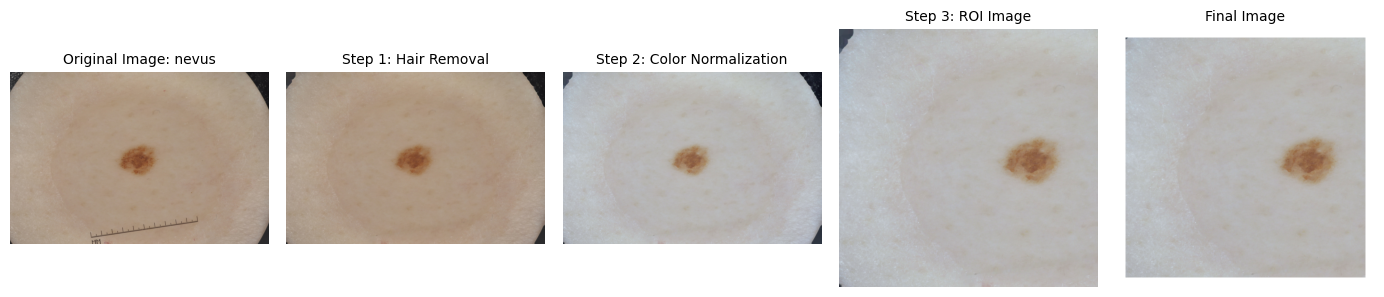

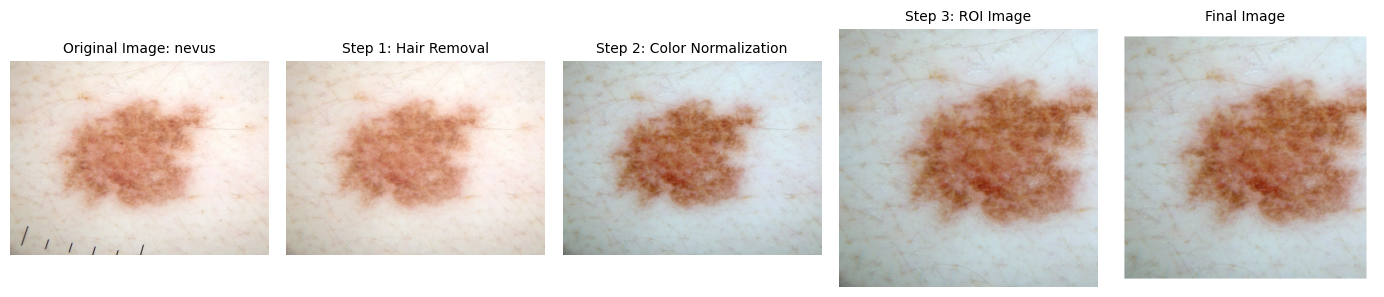

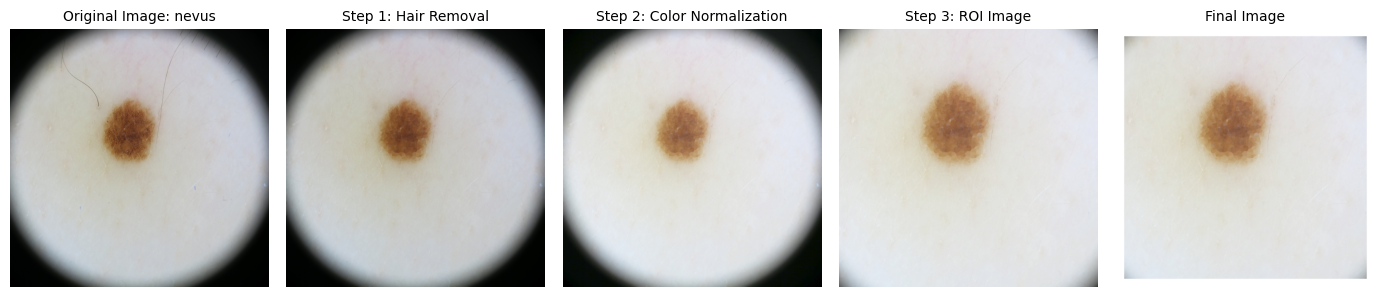

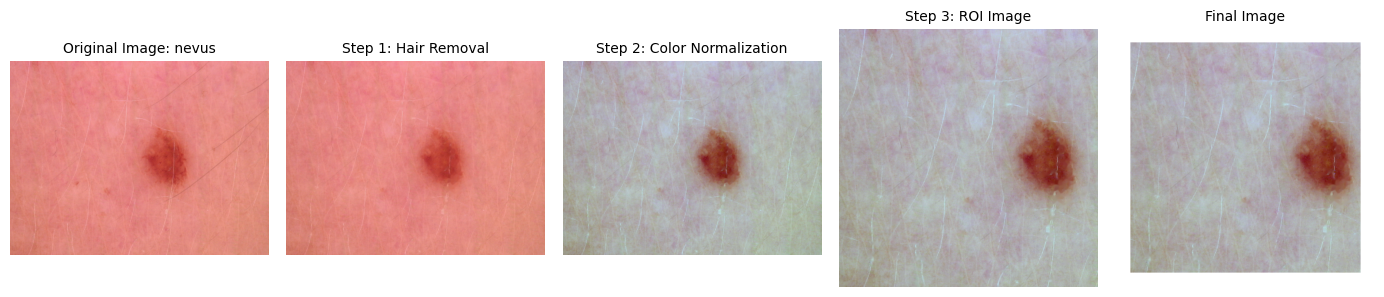

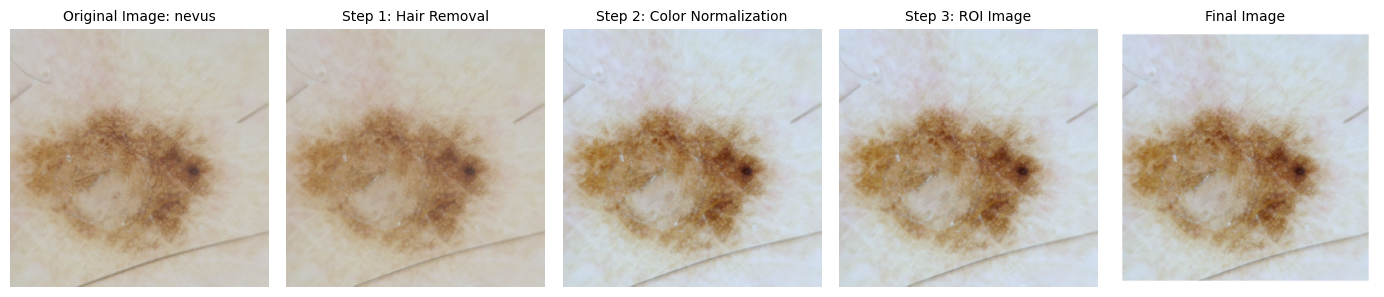

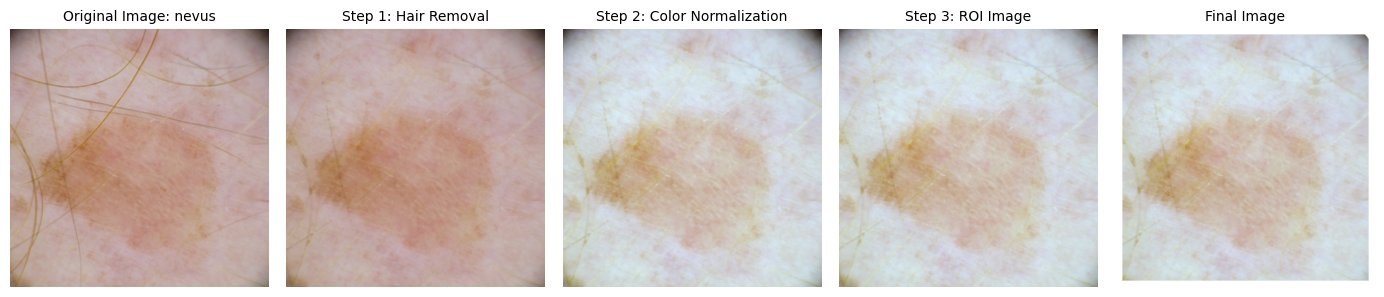

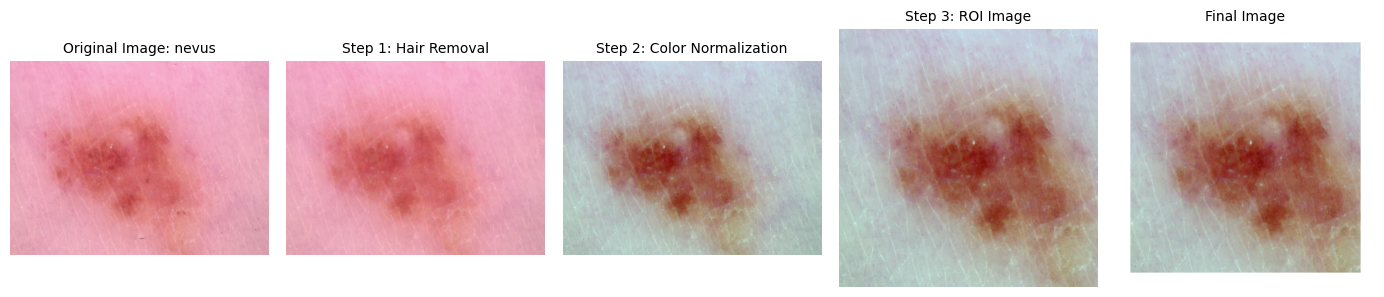

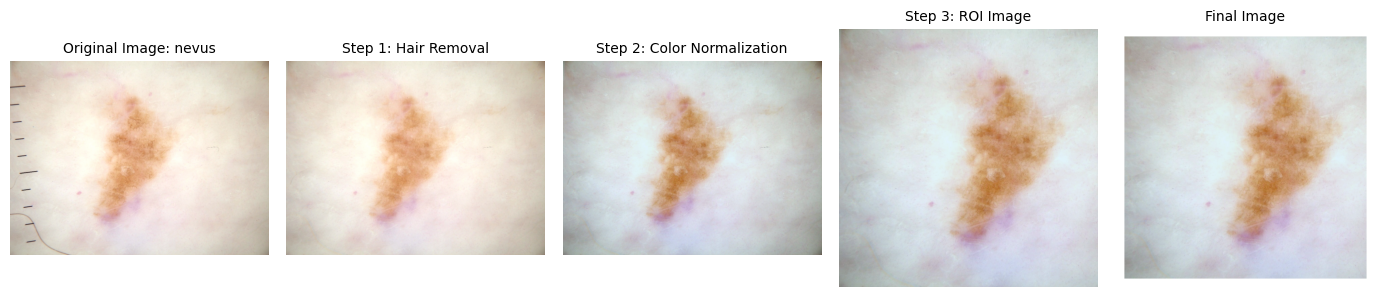

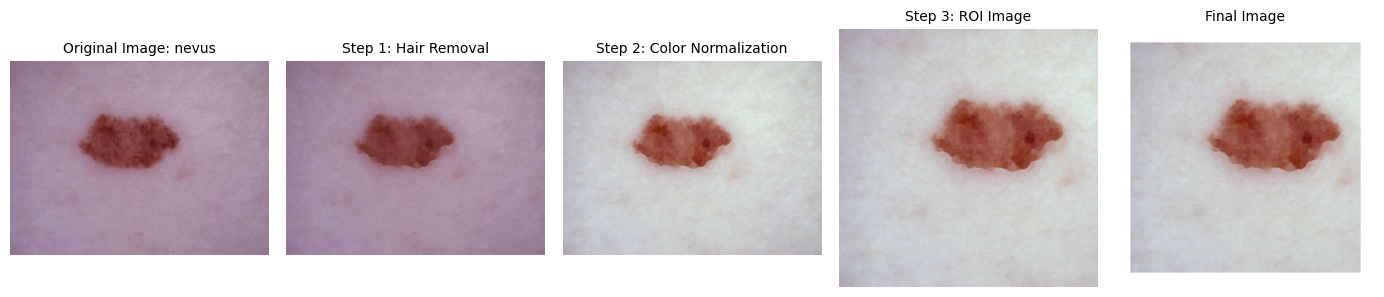

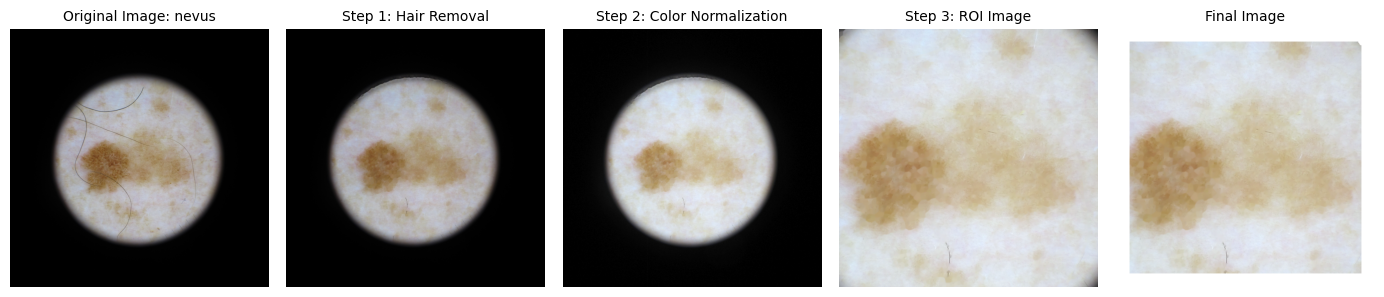

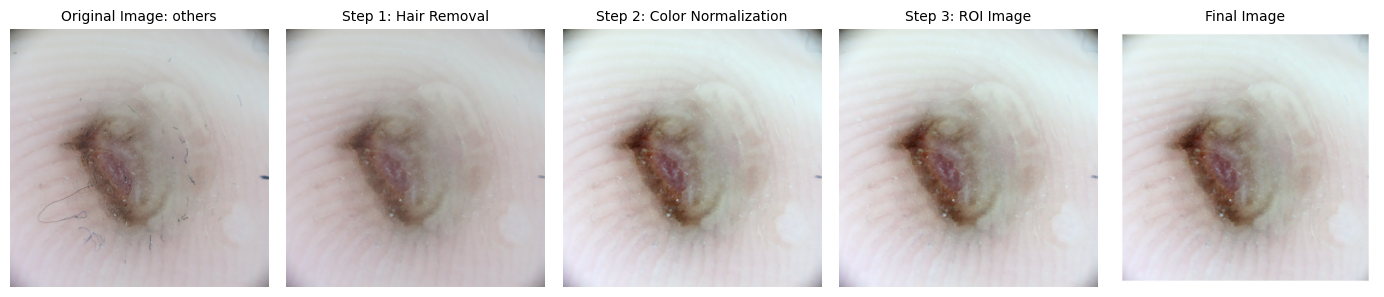

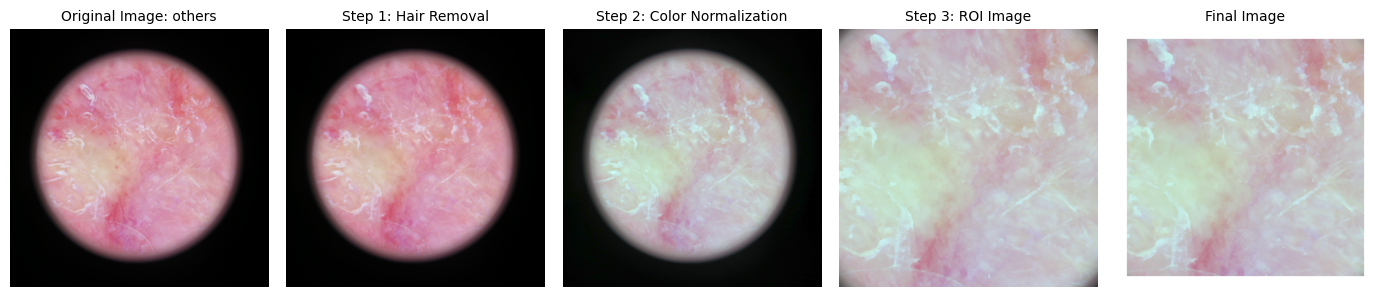

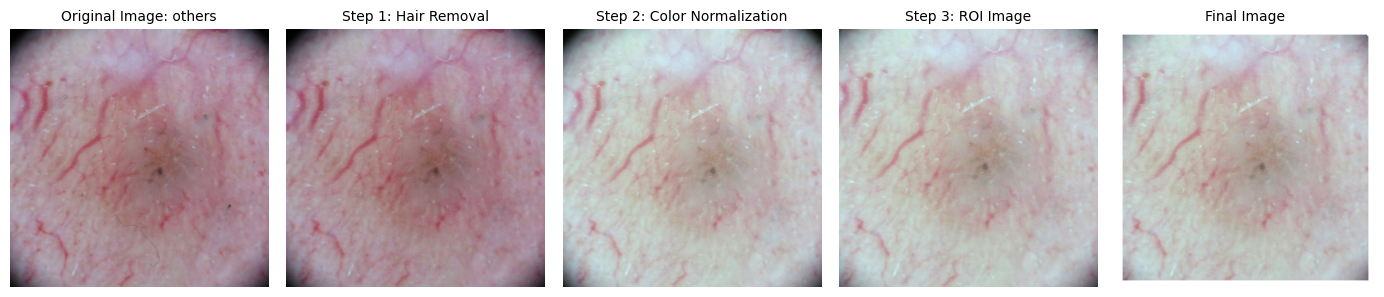

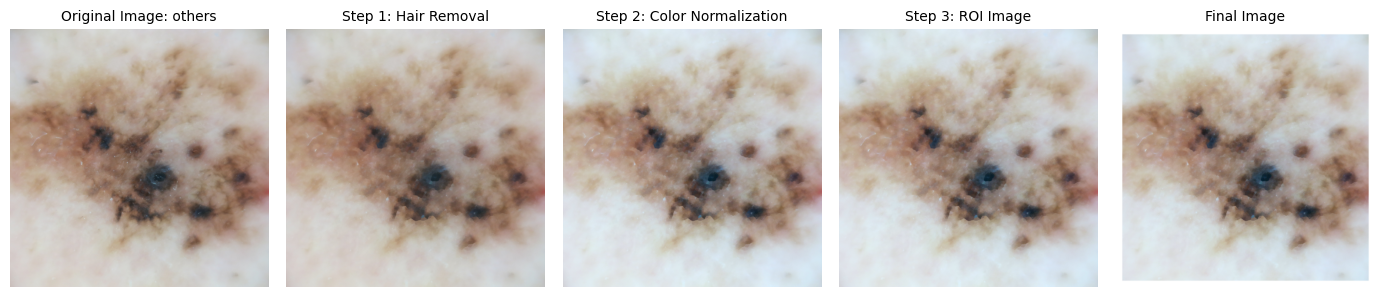

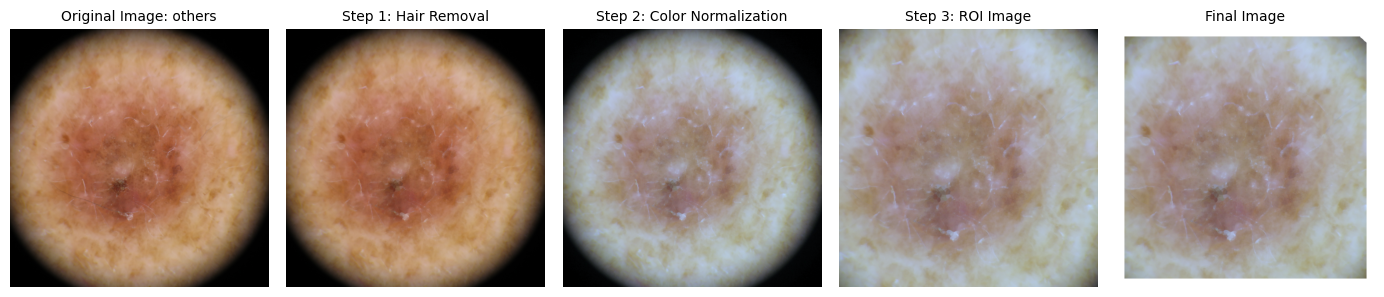

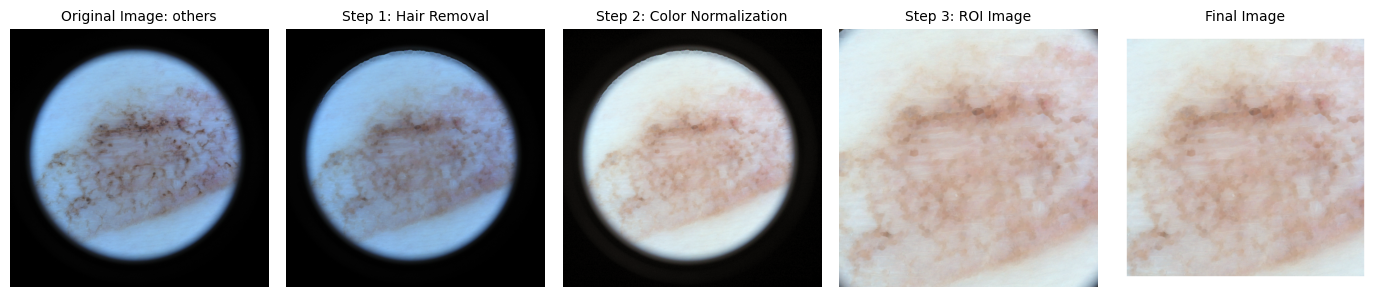

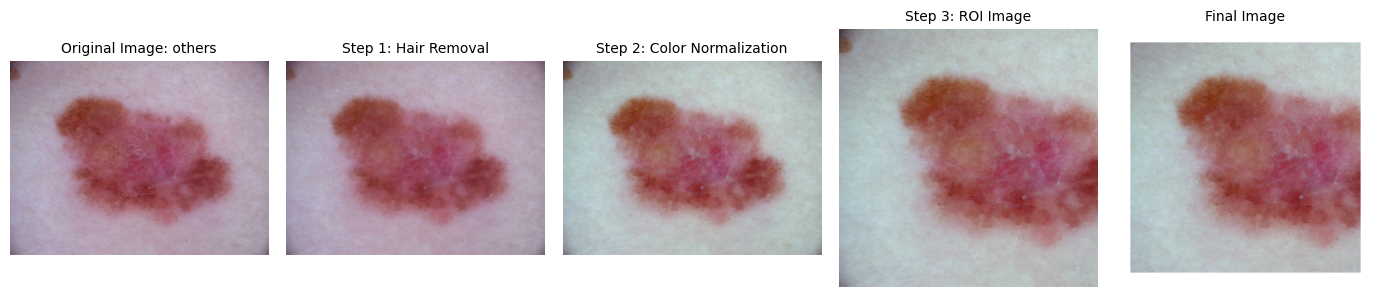

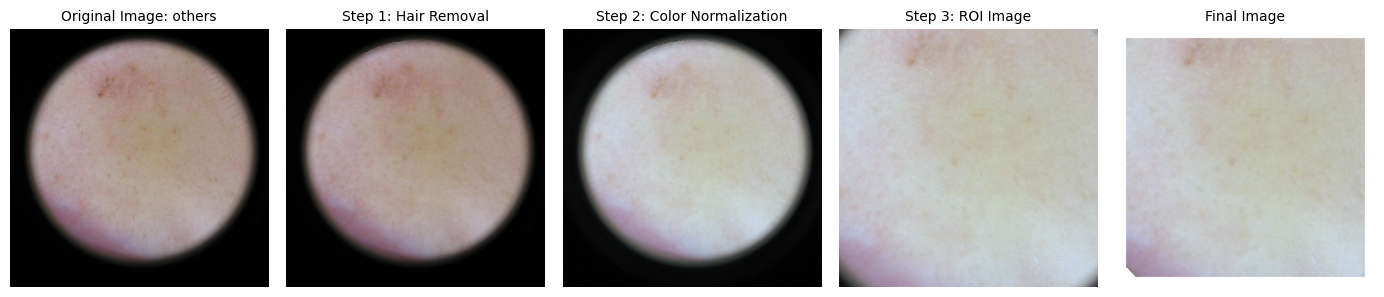

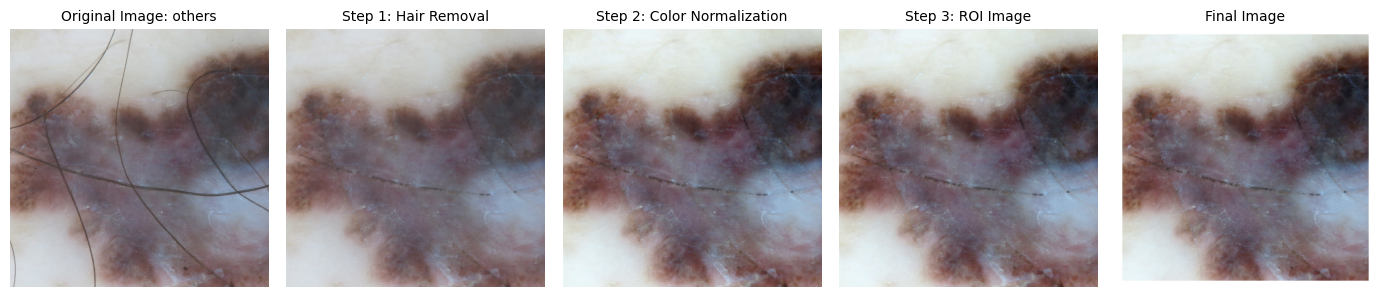

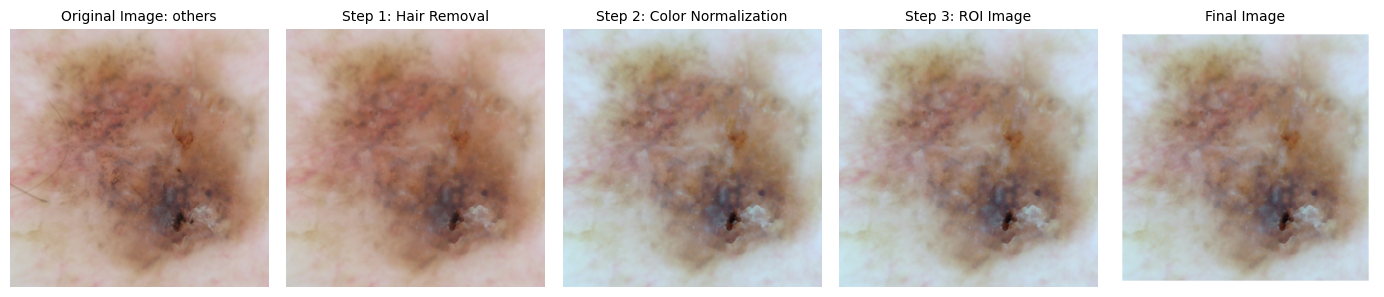

In [43]:
# Use Preprocessing class 

preprocessing = Preprocessing()

for class_idx, c in enumerate(selected_images.keys()):
    for img_idx, img_path in enumerate(selected_images[c]):
        img = cv.imread(img_path)
        preprocessing.preprocess_image(img, c, img_path, True)

# Feature Extraction

In [10]:
class FeatureExtraction:
    """
    FeatureExtraction class. This class's purpose is to extract the features from the image.
    """

    def color_features(self, image: np.ndarray) -> np.ndarray:
        """
        Extract color features (min, max, variance, skewness, kurtosis, median, intensity percentiles, color moments, variegation,
        and entropy) for each channel in RGB, HSV, and LAB color spaces.
    
        Parameters:
            image (np.ndarray): Input image in BGR format.
    
        Returns:
            np.ndarray: A 2D array containing color features, intensity statistics, color moments, variegation, and entropy.
    
        Number of Features Extracted:
            - Color Stats: 45 features (5 statistics: min, max, variance, skewness, kurtosis for each channel in RGB, HSV, and LAB)
            - Intensity Stats: 27 features (median, 25th, and 75th percentiles for each channel in RGB, HSV, and LAB)
            - Color Moments: 12 features (mean, std, skewness, variance for RGB channels)
            - Variegation: 9 features (normalized std for each channel in RGB, HSV, and LAB)
            - Entropy: 9 features (entropy for each channel in RGB, HSV, and LAB)
            - Grayscale Entropy: 1 feature
            - Total: 94 features
        """
        # Convert image to RGB, HSV, and LAB
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image_hsv = cv.cvtColor(image_rgb, cv.COLOR_RGB2HSV)
        image_lab = cv.cvtColor(image_rgb, cv.COLOR_RGB2LAB)
    
        features = []
    
        # Color Stats: min, max, kurtosis for RGB, HSV, LAB
        for color_space in [image_rgb, image_hsv, image_lab]:  # 3 color spaces
            for channel in range(3):  # 3 channels per color space
                channel_data = color_space[:, :, channel]
                features.append(np.min(channel_data))
                features.append(np.max(channel_data))
                features.append(kurtosis(channel_data.flatten()))
    
        # Intensity Stats: median, 25th percentile, 75th percentile for RGB, HSV, LAB
        for color_space in [image_rgb, image_hsv, image_lab]:  # 3 color spaces
            for channel in range(3):  # 3 channels per color space
                channel_data = color_space[:, :, channel]
                features.append(np.median(channel_data))
                features.append(np.percentile(channel_data, 25))
                features.append(np.percentile(channel_data, 75))
        
        # Color Moments for RGB, HSV, and LAB (mean, std, skewness, and variance for each channel)
        color_moments = []
        
        for color_space_name, color_space in zip(['RGB', 'HSV', 'LAB'], [image_rgb, image_hsv, image_lab]):
            c1, c2, c3 = cv.split(color_space)  # Split each color space into channels
            color_moments.extend([
                np.mean(c1), np.mean(c2), np.mean(c3),             # Mean
                np.mean(np.abs(c1 - np.mean(c1)) ** 3) ** (1 / 3), # Skewness (using custom formula)
                np.mean(np.abs(c2 - np.mean(c2)) ** 3) ** (1 / 3),
                np.mean(np.abs(c3 - np.mean(c3)) ** 3) ** (1 / 3),
                np.std(c1) ** 2, np.std(c2) ** 2, np.std(c3) ** 2  # Variance (std squared)
            ])
        
        # Add color moments to features
        features.extend(color_moments)
    
        # Variegation for all color spaces (normalized std for each channel)
        for color_space in [image_rgb, image_hsv, image_lab]:  # 3 color spaces
            for channel in range(3):  # 3 channels per color space
                channel_data = color_space[:, :, channel]
                normalized_std = np.std(channel_data) / (np.max(channel_data) + 1e-5)
                features.append(normalized_std)
    
        # Entropy for each channel in each color space (RGB, HSV, LAB)
        for color_space in [image_rgb, image_hsv, image_lab]:  # 3 color spaces
            for channel in range(3):  # 3 channels per color space
                channel_data = color_space[:, :, channel]
                histogram = cv.calcHist([channel_data], [0], None, [256], [0, 256])
                histogram /= histogram.sum()
                channel_entropy = -np.sum(histogram * np.log2(histogram + np.finfo(float).eps))
                features.append(channel_entropy)
    
        # Entropy of the grayscale image
        gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        histogram = cv.calcHist([gray_image], [0], None, [256], [0, 256])
        histogram /= histogram.sum()
        entropy = -np.sum(histogram * np.log2(histogram + np.finfo(float).eps))
        features.append(entropy)

    
        return np.array(features).reshape(1, -1)

    def calculate_normalized_histogram(self, channel: np.ndarray, n_bins: int, range_min: int, range_max: int) -> np.ndarray:
        """
        Calculate the normalized histogram of an image channel.

        Parameters:
            channel (np.ndarray): Input image channel.
            n_bins (int): Number of histogram bins.
            range_min (int): Minimum value of the histogram range.
            range_max (int): Maximum value of the histogram range.

        Returns:
            np.ndarray: A 1D array representing the normalized histogram.
        """
        hist = cv.calcHist([channel], [0], None, [n_bins], [range_min, range_max])
        hist = cv.normalize(hist, hist, alpha=0, beta=1, norm_type=cv.NORM_L1)

        return hist.flatten()  # Flatten the histogram for concatenation


    def color_histogram(self, Img: np.ndarray, n_bins: int = 256):
        """
        Extract color histogram features from RGB, HSV, and LAB color spaces.

        Parameters:
            Img (np.ndarray): Input image in RGB format.
            n_bins (int): Number of histogram bins (default is 256).

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray]: 
                - A 2D array with shape (1, 192) for RGB histogram.
                - A 2D array with shape (1, 192) for HSV histogram.
                - A 2D array with shape (1, 192) for LAB histogram.

        Number of Features Extracted:
            576 (192 features from each of the 3 color spaces).
        """
        ranges_dict = {
            'RGB': [(0, 256), (0, 256), (0, 256)],
            'HSV': [(0, 180), (0, 256), (0, 256)],
            'LAB': [(0, 100), (-128, 128), (-128, 128)]
        }

        # Split RGB channels
        rgb_channels = cv.split(Img)

        # Convert image to HSV and split channels
        hsv_image = cv.cvtColor(Img, cv.COLOR_RGB2HSV)
        hsv_channels = cv.split(hsv_image)

        # Convert image to LAB and split channels
        lab_image = cv.cvtColor(Img, cv.COLOR_RGB2LAB)
        lab_channels = cv.split(lab_image)

        # Compute normalized histograms for each channel in each color space
        rgb_hist = np.concatenate([self.calculate_normalized_histogram(channel, n_bins, *ranges_dict['RGB'][i]) for i, channel in enumerate(rgb_channels)])
        hsv_hist = np.concatenate([self.calculate_normalized_histogram(channel, n_bins, *ranges_dict['HSV'][i]) for i, channel in enumerate(hsv_channels)])
        lab_hist = np.concatenate([self.calculate_normalized_histogram(channel, n_bins, *ranges_dict['LAB'][i]) for i, channel in enumerate(lab_channels)])

        return rgb_hist.reshape(1, -1), hsv_hist.reshape(1, -1), lab_hist.reshape(1, -1)


    def lbp_feature(self, Img: np.ndarray, P: int = 16, R: int = 2) -> np.ndarray:
        """
        Extract Local Binary Pattern (LBP) features from the blue channel of the image.

        Parameters:
            Img (np.ndarray): Input image in RGB format.
            P (int): Number of circularly symmetric neighbor set points.
            R (int): Radius of circle.

        Returns:
            np.ndarray: A 2D array with shape (1, 18) representing LBP features.

        Number of Features Extracted:
            18 (using uniform LBP with P=16).
        """
        blue_Img = Img[:, :, 2]
        lbp = local_binary_pattern(blue_Img, P, R, method='uniform')
        n_bins = int(lbp.max() + 1)
        lbp_fd, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
        return np.array(lbp_fd).reshape(1, -1)
    

    def glcm_feature(self, Img: np.ndarray) -> np.ndarray:
        """
        Extract Gray Level Co-occurrence Matrix (GLCM) features from the blue channel of the image.

        Parameters:
            Img (np.ndarray): Input image in RGB format.

        Returns:
            np.ndarray: A 2D array with shape (1, 20) representing GLCM features.

        Number of Features Extracted:
            20 (5 properties extracted for 4 angles).
        """
        blue_Img = Img[:, :, 2]
        distance = [1]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        properties = ['correlation', 'homogeneity', 'contrast', 'energy', 'dissimilarity']
        glcm_mat = graycomatrix(blue_Img, distances=distance, angles=angles, symmetric=True, normed=True)
        glcm_fd = np.hstack([graycoprops(glcm_mat, props).ravel() for props in properties])
        return np.array(glcm_fd).reshape(1, -1)

    def haralick_feature(self, Img: np.ndarray) -> np.ndarray:
        """
        Extract Haralick features from the blue channel of the image.

        Parameters:
            Img (np.ndarray): Input image in RGB format.

        Returns:
            np.ndarray: A 2D array with shape (1, 13) representing Haralick features.

        Number of Features Extracted:
            13
        """
        blue_Img = Img[:, :, 2]  # Use the blue channel of the image
        haralick_fd = mahotas.features.haralick(blue_Img).mean(axis=0)
        return np.array(haralick_fd).reshape(1, -1)

    def wavelet_transform_feature(self, image: np.ndarray) -> np.ndarray:
        """
        Extract wavelet transform features from the grayscale image.
    
        Parameters:
            image (np.ndarray): Input image in BGR format.
    
        Returns:
            np.ndarray: A 2D array with shape (1, 15) representing wavelet transform features.
    
        Number of Features Extracted:
            15 (5 levels of decomposition with 3 features each - mean, standard deviation, and energy).
        """
        gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        coeffs = pywt.wavedec2(gray_image, 'db1', level=4)  # Adjust wavelet type and level as needed

        wavelet_features = []
        for coeff in coeffs:
            wavelet_features.append(np.mean(coeff))
            wavelet_features.append(np.std(coeff))
            wavelet_features.append(np.sum(np.square(coeff)))  # Energy

        return np.array(wavelet_features).reshape(1, -1)


    def count_features(self, image: np.ndarray) -> dict:
        """
        Returns a dictionary with the count of features extracted by each method and the total count.
        """
        color_stats_features = self.color_features(image)
        rgb_histogram, hsv_histogram, lab_histogram = self.color_histogram(image, 64)
        lbp_features = self.lbp_feature(image, 16, 2)
        glcm_features = self.glcm_feature(image)
        haralick_features = self.haralick_feature(image)
        wavelet_features = self.wavelet_transform_feature(image)
    
        # Get the number of features for each method
        num_color_stats = color_stats_features.shape[1]
        num_rgb_hist = rgb_histogram.shape[1]
        num_hsv_hist = hsv_histogram.shape[1]
        num_lab_hist = lab_histogram.shape[1]
        num_lbp = lbp_features.shape[1]
        num_glcm = glcm_features.shape[1]
        num_haralick = haralick_features.shape[1]
        num_wavelet = wavelet_features.shape[1]
    
        # Calculate the total number of features
        total_features = (
            num_color_stats +
            num_rgb_hist +
            num_hsv_hist +
            num_lab_hist +
            num_lbp +
            num_glcm +
            num_haralick +
            num_wavelet
        )
    
        return {
            "color_stats": num_color_stats,
            "rgb_histogram": num_rgb_hist,
            "hsv_histogram": num_hsv_hist,
            "lab_histogram": num_lab_hist,
            "lbp": num_lbp,
            "glcm": num_glcm,
            "haralick": num_haralick,
            "wavelet": num_wavelet,
            "total": total_features
        }

    def extract_all(self, image: np.ndarray) -> pd.DataFrame:
        """
        Extract all features from the image and return them in a DataFrame.
        """
        color_stats_features = self.color_features(image)  # 100 features
        rgb_histogram, hsv_histogram, lab_histogram = self.color_histogram(image, 64)  # 192 features each
        lbp_features = self.lbp_feature(image, 16, 2)  # 27 features
        glcm_features = self.glcm_feature(image)  # 20 features
        haralick_features = self.haralick_feature(image)  # 13 features
        wavelet_features = self.wavelet_transform_feature(image)  # 15 features
    
        # Concatenate all histograms
        color_histogram_features = np.concatenate([rgb_histogram, hsv_histogram, lab_histogram], axis=1)  # 576 features
    
        # Concatenate all features into a single feature vector
        features = np.concatenate([
            color_stats_features,  # 100 features
            color_histogram_features,  # 576 features
            lbp_features,  # 18 features
            glcm_features,  # 20 features
            haralick_features,  # 13 features
            wavelet_features  # 15 features
            ], axis=1)  # Total: 742 features
    
        # Define column names for all features
        column_names = []
    
        column_names = []

        # Color Stats (min, max, kurtosis for each channel in RGB, HSV, LAB)
        for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
            column_names.extend([f"{prefix}_{stat}_{color_space}" for stat in ["min", "max", "kurtosis"]])
        
        # Intensity Stats (median, 25th percentile, 75th percentile for each channel in RGB, HSV, LAB)
        for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
            column_names.extend([f"{prefix}_{stat}_{color_space}" for stat in ["median", "25_percentile", "75_percentile"]])
        
        # Color Moments (mean, skewness, variance for each channel in RGB, HSV, LAB)
        for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
            column_names.extend([f"{prefix}_{moment}_{color_space}" for moment in ["mean", "skewness", "variance"]])
        
        # Variegation (normalized std for each channel in RGB, HSV, LAB)
        for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
            column_names.append(f"{prefix}_variegation_{color_space}")
        
        # Entropy for each channel in RGB, HSV, LAB
        for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
            column_names.append(f"{prefix}_entropy_{color_space}")
        
        # Grayscale Entropy (single feature)
        column_names.append("grayscale_entropy")

        # RGB, HSV, LAB Histograms
        column_names.extend([f"rgb_histogram_bin_{i}_channel_{channel}" for channel in ['R', 'G', 'B'] for i in range(64)])
        column_names.extend([f"hsv_histogram_bin_{i}_channel_{channel}" for channel in ['H', 'S', 'V'] for i in range(64)])
        column_names.extend([f"lab_histogram_bin_{i}_channel_{channel}" for channel in ['L', 'A', 'B'] for i in range(64)])  # 576 features
    
        # LBP
        column_names.extend([f"lbp_feature_bin_{i}" for i in range(18)])  # 18 features
    
        # GLCM
        properties = ['correlation', 'homogeneity', 'contrast', 'energy', 'dissimilarity']
        angles = ['0', '45', '90', '135']
        column_names.extend([f"glcm_{prop}_angle_{angle}" for prop in properties for angle in angles])  # 20 features
    
        # Haralick
        column_names.extend([f"haralick_feature_{i}" for i in range(13)])  # 13 features
    
        # Wavelet
        wavelet_levels = [f"Wavelet_Level_{i}" for i in range(5)]
        wavelet_stats = ['Mean', 'Std', 'Energy']
        column_names.extend([f"{level}_{stat}" for level in wavelet_levels for stat in wavelet_stats])  # 15 features
    
        # Verify column count
        expected_feature_count = 742
        assert len(column_names) == expected_feature_count, f"Expected {expected_feature_count} column names, got {len(column_names)}"
    
        # Create DataFrame
        image_feature_df = pd.DataFrame(features, columns=column_names)
        return image_feature_df

## Create a smaller version of the training set and apply Preprocessing and FeatureExtraction

In [28]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into 1000 samples while maintaining the class ratio
df_train_sample, _ = train_test_split(df_train, train_size=5000, stratify=df_train['label'], random_state=42)

# Check the distribution
print(df_train_sample['label'].value_counts())

label
nevus     2542
others    2458
Name: count, dtype: int64


# Preprocessing and FeatureExtraction Class Initialization

In [11]:
preprocessor = Preprocessing()
feature_extractor = FeatureExtraction()

In [14]:
feature_extractor.count_features(img)

{'color_stats': 100,
 'rgb_histogram': 192,
 'hsv_histogram': 192,
 'lab_histogram': 192,
 'lbp': 18,
 'glcm': 20,
 'haralick': 13,
 'wavelet': 15,
 'total': 742}

# Extracting features from Train set

In [15]:
# Placeholder for new DataFrame to store features
features_list = []

# Loop through each row to preprocess the image and extract features
for _, row in df_train.iterrows():
    image_path = row['image_path']
    label = row['label']
    
    # Load the image (ensure image paths are valid)
    img = cv.imread(image_path)
    if img is None:
        print(f"Image at path {image_path} not found.")
        continue
    
    # Preprocess the image (assuming preprocessor function is defined elsewhere)
    preprocessed_img = preprocessor.preprocess_image(img, image_path, False)
    
    # Extract features from the preprocessed image
    features_df = feature_extractor.extract_all(preprocessed_img)
    
    # Append features and label to the list as a flattened array
    features_list.append([*features_df.values.flatten(), label])

# Generate feature names from the FeatureExtraction class as per final color_features method
column_names = []

# Color Stats (min, max, kurtosis for RGB, HSV, LAB channels)
for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
    column_names.extend([f"{prefix}_{stat}_{color_space}" for stat in ["min", "max", "kurtosis"]])

# Intensity Stats (median, 25th percentile, 75th percentile for each channel in RGB, HSV, LAB)
for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
    column_names.extend([f"{prefix}_{stat}_{color_space}" for stat in ["median", "25_percentile", "75_percentile"]])

# Color Moments (mean, skewness, variance for each channel in RGB, HSV, LAB)
for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
    column_names.extend([f"{prefix}_{moment}_{color_space}" for moment in ["mean", "skewness", "variance"]])

# Variegation (normalized std for each channel in RGB, HSV, LAB)
for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
    column_names.append(f"{prefix}_variegation_{color_space}")

# Entropy for each channel in RGB, HSV, LAB
for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
    column_names.append(f"{prefix}_entropy_{color_space}")

# Grayscale Entropy (single feature)
column_names.append("grayscale_entropy")

# RGB histogram features
column_names.extend([f"rgb_histogram_bin_{i}_channel_{channel}" for channel in ['R', 'G', 'B'] for i in range(64)])  # 192 features

# HSV histogram features
column_names.extend([f"hsv_histogram_bin_{i}_channel_{channel}" for channel in ['H', 'S', 'V'] for i in range(64)])  # 192 features

# LAB histogram features
column_names.extend([f"lab_histogram_bin_{i}_channel_{channel}" for channel in ['L', 'A', 'B'] for i in range(64)])  # 192 features

# LBP features
column_names.extend([f"lbp_feature_bin_{i}" for i in range(18)])  # 18 features

# GLCM features
properties = ['correlation', 'homogeneity', 'contrast', 'energy', 'dissimilarity']
angles = ['0', '45', '90', '135']
column_names.extend([f"glcm_{prop}_angle_{angle}" for prop in properties for angle in angles])  # 20 features

# Haralick features
column_names.extend([f"haralick_feature_{i}" for i in range(13)])  # 13 features

# Wavelet Transform features
wavelet_levels = [f"Wavelet_Level_{i}" for i in range(5)]
wavelet_stats = ['Mean', 'Std', 'Energy']
column_names.extend([f"{level}_{stat}" for level in wavelet_levels for stat in wavelet_stats])  # 15 features

# Verify column count
expected_feature_count = 742  # Updated based on the current FeatureExtraction method
assert len(column_names) == expected_feature_count, f"Expected {expected_feature_count} column names, got {len(column_names)}"

# Add label column
column_names.append('label')

# Create a new DataFrame with the extracted features
df_features = pd.DataFrame(features_list, columns=column_names)

# Display the first few rows of the features DataFrame to verify
print(df_features.head())


   RGB_min_R  RGB_max_R  RGB_kurtosis_R  RGB_min_G  RGB_max_G  RGB_kurtosis_G  \
0       81.0      255.0        0.025752        1.0      255.0        2.347306   
1       98.0      255.0       -0.102219        6.0      255.0       -0.256896   
2      112.0      255.0        4.022853       82.0      255.0        4.156873   
3       78.0      255.0       -0.255642       33.0      255.0       -0.486975   
4      105.0      255.0        2.299421       34.0      255.0        2.342910   

   RGB_min_B  RGB_max_B  RGB_kurtosis_B  HSV_min_H  ...  Wavelet_Level_2_Mean  \
0       10.0      255.0        2.031273        0.0  ...             -0.055838   
1        1.0      255.0       -0.333008        0.0  ...             -0.049861   
2       55.0      255.0        3.194763        0.0  ...             -0.331003   
3        0.0      255.0       -0.578015        0.0  ...              0.140915   
4        0.0      255.0        1.481656        0.0  ...             -0.028760   

   Wavelet_Level_2_Std  Wa

In [16]:
df_features.head()

RGB_min_R  RGB_max_R  RGB_kurtosis_R  RGB_min_G  RGB_max_G  RGB_kurtosis_G  \
0       81.0      255.0        0.025752        1.0      255.0        2.347306   
1       98.0      255.0       -0.102219        6.0      255.0       -0.256896   
2      112.0      255.0        4.022853       82.0      255.0        4.156873   
3       78.0      255.0       -0.255642       33.0      255.0       -0.486975   
4      105.0      255.0        2.299421       34.0      255.0        2.342910   

   RGB_min_B  RGB_max_B  RGB_kurtosis_B  HSV_min_H  ...  Wavelet_Level_2_Mean  \
0       10.0      255.0        2.031273        0.0  ...             -0.055838   
1        1.0      255.0       -0.333008        0.0  ...             -0.049861   
2       55.0      255.0        3.194763        0.0  ...             -0.331003   
3        0.0      255.0       -0.578015        0.0  ...              0.140915   
4        0.0      255.0        1.481656        0.0  ...             -0.028760   

   Wavelet_Level_2_Std  Wavelet_Level_2_Energy  Wavelet_Level_3_Mean  \
0            17.069209            2.839896e+06              0.003015   
1            20.329176            4.028220e+06              0.004594   
2            12.727097            7.719954e+06             -0.169501   
3            19.514917            3.712163e+06             -0.002167   
4             9.144507            4.110229e+06             -0.006837   

   Wavelet_Level_3_Std  Wavelet_Level_3_Energy  Wavelet_Level_4_Mean  \
0             9.896600            3.751891e+06             -0.001495   
1            13.013401            6.487238e+06              0.017067   
2             8.237868            1.293409e+07              0.085449   
3             7.194295            1.982689e+06             -0.020767   
4             3.855936            2.923225e+06              0.004554   

   Wavelet_Level_4_Std  Wavelet_Level_4_Energy  label  
0             6.370118              6162844.50  nevus  
1             8.690407             11470126.00  nevus  
2             2.632162              5285242.50  nevus  
3             3.242860              1597204.50  nevus  
4             2.026826              3230698.75  nevus  

[5 rows x 743 columns]

In [17]:
def extract_hog_features(img: np.ndarray, resize_dim: Tuple[int, int] = (96, 128)) -> np.ndarray:
    """
    Extract HOG features from a single image.
    
    Parameters:
        img (np.ndarray): Input image in RGB format.
        resize_dim (Tuple[int, int]): The dimensions (width, height) to which the image is resized.
    
    Returns:
        np.ndarray: HOG features for the input image.
    """
    # Step 1: Resize the image
    resized_img = cv.resize(img, resize_dim)
    
    # Step 2: Convert to grayscale (HOG works on grayscale images)
    gray_img = cv.cvtColor(resized_img, cv.COLOR_RGB2GRAY)
    
    # Step 3: Extract HOG features
    hog_features = hog(
        gray_img, 
        orientations=9, 
        pixels_per_cell=(8, 8), 
        cells_per_block=(2, 2), 
        block_norm='L2-Hys', 
        channel_axis=None  # Not a multichannel image anymore
    )
    
    return hog_features

In [18]:
hog_features_list = []

# Loop through each row to preprocess the image and extract features
for _, row in df_train.iterrows():
    image_path = row['image_path']
    label = row['label']
    
    # Preprocess the image
    preprocessed_img = preprocessor.preprocess_image(img, image_path, False)
    
    # Extract HOG features and store separately
    hog_features = extract_hog_features(preprocessed_img)
    hog_features_list.append(hog_features.flatten())  # Flatten for concatenation later

# Step 2: Apply PCA on all HOG features
hog_features_matrix = np.array(hog_features_list)  # Convert to matrix for PCA
pca = PCA(n_components=100)  # Reduce HOG features to 100 components
hog_pca_features = pca.fit_transform(hog_features_matrix)

# Step 3: Convert HOG+PCA features directly to a DataFrame
hog_pca_column_names = [f'hog_pca_{i}' for i in range(hog_pca_features.shape[1])]
df_hog_pca = pd.DataFrame(hog_pca_features, columns=hog_pca_column_names)

# Display the first few rows of the HOG+PCA features DataFrame
print(df_hog_pca.head())

      hog_pca_0     hog_pca_1     hog_pca_2     hog_pca_3     hog_pca_4  \
0  2.686043e-12  1.804899e-26  1.404250e-26 -1.854009e-27 -2.230347e-27   
1  2.686043e-12 -6.272566e-27 -2.275001e-27 -6.019493e-27 -5.183278e-27   
2  2.686043e-12  3.238369e-30 -3.999172e-28  9.959424e-28 -6.391220e-28   
3  2.686043e-12  1.517291e-27  5.505227e-28 -2.418835e-27 -6.459729e-27   
4  2.686043e-12  1.068532e-27 -9.439667e-28  3.189306e-27 -2.851303e-28   

      hog_pca_5     hog_pca_6     hog_pca_7     hog_pca_8     hog_pca_9  ...  \
0 -4.575438e-27  1.837236e-27 -4.979889e-27 -7.063980e-28 -2.723098e-28  ...   
1  2.312346e-27  3.977446e-27 -3.408191e-27 -2.571524e-28 -1.485707e-27  ...   
2 -1.645647e-27 -4.245735e-27  4.610288e-27  4.196988e-27  2.022921e-27  ...   
3 -6.399572e-27 -2.913852e-27 -5.147467e-27  4.127286e-27 -7.670111e-27  ...   
4  1.999766e-27 -3.773280e-27 -9.376458e-28 -4.514155e-27 -5.071018e-28  ...   

     hog_pca_90    hog_pca_91    hog_pca_92    hog_pca_93    hog_pca

In [19]:
# Ensure that df_features and df_hog_pca have the same number of rows
if len(df_features) == len(df_hog_pca):
    # Concatenate df_features (without label) and df_hog_pca along columns
    df_final = pd.concat([df_features.drop(columns='label'), df_hog_pca], axis=1)

    # Add the label column back
    df_final['label'] = df_features['label'].values

    # Display the first few rows of the final DataFrame
    print(df_final.head())
else:
    print("Error: Mismatch in the number of rows between df_features and df_hog_pca")

   RGB_min_R  RGB_max_R  RGB_kurtosis_R  RGB_min_G  RGB_max_G  RGB_kurtosis_G  \
0       81.0      255.0        0.025752        1.0      255.0        2.347306   
1       98.0      255.0       -0.102219        6.0      255.0       -0.256896   
2      112.0      255.0        4.022853       82.0      255.0        4.156873   
3       78.0      255.0       -0.255642       33.0      255.0       -0.486975   
4      105.0      255.0        2.299421       34.0      255.0        2.342910   

   RGB_min_B  RGB_max_B  RGB_kurtosis_B  HSV_min_H  ...    hog_pca_91  \
0       10.0      255.0        2.031273        0.0  ... -1.441540e-28   
1        1.0      255.0       -0.333008        0.0  ...  2.152441e-28   
2       55.0      255.0        3.194763        0.0  ...  6.360555e-28   
3        0.0      255.0       -0.578015        0.0  ... -7.940437e-28   
4        0.0      255.0        1.481656        0.0  ... -3.064893e-28   

     hog_pca_92    hog_pca_93    hog_pca_94    hog_pca_95    hog_pca_96  \

In [20]:
# Save the DataFrame as a CSV file
df_final.to_csv('features_dataset_full_v2.csv', index=False)

# Extracting features from Valid set

In [21]:
# Placeholder for new DataFrame to store features
features_list_valid = []

# Loop through each row to preprocess the image and extract features
for _, row in df_valid.iterrows():
    image_path = row['image_path']
    label = row['label']
    
    # Load the image (ensure image paths are valid)
    img = cv.imread(image_path)
    if img is None:
        print(f"Image at path {image_path} not found.")
        continue
    
    # Preprocess the image (assuming preprocessor function is defined elsewhere)
    preprocessed_img = preprocessor.preprocess_image(img, image_path, False)
    
    # Extract features from the preprocessed image
    features_df = feature_extractor.extract_all(preprocessed_img)
    
    # Append features and label to the list as a flattened array
    features_list_valid.append([*features_df.values.flatten(), label])

# Generate feature names from the FeatureExtraction class as per final color_features method
column_names = []

# Color Stats (min, max, kurtosis for RGB, HSV, LAB channels)
for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
    column_names.extend([f"{prefix}_{stat}_{color_space}" for stat in ["min", "max", "kurtosis"]])

# Intensity Stats (median, 25th percentile, 75th percentile for each channel in RGB, HSV, LAB)
for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
    column_names.extend([f"{prefix}_{stat}_{color_space}" for stat in ["median", "25_percentile", "75_percentile"]])

# Color Moments (mean, skewness, variance for each channel in RGB, HSV, LAB)
for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
    column_names.extend([f"{prefix}_{moment}_{color_space}" for moment in ["mean", "skewness", "variance"]])

# Variegation (normalized std for each channel in RGB, HSV, LAB)
for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
    column_names.append(f"{prefix}_variegation_{color_space}")

# Entropy for each channel in RGB, HSV, LAB
for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
    column_names.append(f"{prefix}_entropy_{color_space}")

# Grayscale Entropy (single feature)
column_names.append("grayscale_entropy")

# RGB histogram features
column_names.extend([f"rgb_histogram_bin_{i}_channel_{channel}" for channel in ['R', 'G', 'B'] for i in range(64)])  # 192 features

# HSV histogram features
column_names.extend([f"hsv_histogram_bin_{i}_channel_{channel}" for channel in ['H', 'S', 'V'] for i in range(64)])  # 192 features

# LAB histogram features
column_names.extend([f"lab_histogram_bin_{i}_channel_{channel}" for channel in ['L', 'A', 'B'] for i in range(64)])  # 192 features

# LBP features
column_names.extend([f"lbp_feature_bin_{i}" for i in range(18)])  # 18 features

# GLCM features
properties = ['correlation', 'homogeneity', 'contrast', 'energy', 'dissimilarity']
angles = ['0', '45', '90', '135']
column_names.extend([f"glcm_{prop}_angle_{angle}" for prop in properties for angle in angles])  # 20 features

# Haralick features
column_names.extend([f"haralick_feature_{i}" for i in range(13)])  # 13 features

# Wavelet Transform features
wavelet_levels = [f"Wavelet_Level_{i}" for i in range(5)]
wavelet_stats = ['Mean', 'Std', 'Energy']
column_names.extend([f"{level}_{stat}" for level in wavelet_levels for stat in wavelet_stats])  # 15 features

# Verify column count
expected_feature_count = 742  # Updated based on the current FeatureExtraction method
assert len(column_names) == expected_feature_count, f"Expected {expected_feature_count} column names, got {len(column_names)}"

# Add label column
column_names.append('label')

# Create a new DataFrame with the extracted features
df_features_valid = pd.DataFrame(features_list_valid, columns=column_names)

# Display the first few rows of the features DataFrame to verify
print(df_features_valid.head())


   RGB_min_R  RGB_max_R  RGB_kurtosis_R  RGB_min_G  RGB_max_G  RGB_kurtosis_G  \
0       81.0      255.0       -0.253377        1.0      255.0       -0.152697   
1      109.0      255.0        1.949790       44.0      255.0        0.354138   
2      103.0      255.0       -0.560795       67.0      255.0        0.466925   
3       53.0      255.0       -0.332051       27.0      255.0       -0.559111   
4       90.0      255.0        3.229122        3.0      255.0        4.555366   

   RGB_min_B  RGB_max_B  RGB_kurtosis_B  HSV_min_H  ...  Wavelet_Level_2_Mean  \
0        9.0      255.0       -0.291250        0.0  ...             -0.100249   
1        1.0      255.0        0.568919        0.0  ...              0.032041   
2       33.0      255.0        1.260404        0.0  ...             -0.803266   
3       15.0      255.0       -0.592239        0.0  ...              0.429542   
4        6.0      255.0        3.749910        0.0  ...             -0.025328   

   Wavelet_Level_2_Std  Wa

In [22]:
hog_features_list_valid = []

# Loop through each row to preprocess the image and extract features
for _, row in df_valid.iterrows():
    image_path = row['image_path']
    label = row['label']
    
    # Preprocess the image
    preprocessed_img = preprocessor.preprocess_image(img, image_path, False)
    
    # Extract HOG features and store separately
    hog_features = extract_hog_features(preprocessed_img)
    hog_features_list_valid.append(hog_features.flatten())  # Flatten for concatenation later

# Step 2: Apply PCA on all HOG features
hog_features_valid_matrix = np.array(hog_features_list_valid)  # Convert to matrix for PCA
pca = PCA(n_components=100)  # Reduce HOG features to 100 components
hog_pca_features_valid = pca.fit_transform(hog_features_valid_matrix)

# Step 3: Convert HOG+PCA features directly to a DataFrame
hog_pca_column_names = [f'hog_pca_{i}' for i in range(hog_pca_features_valid.shape[1])]
df_hog_pca_valid = pd.DataFrame(hog_pca_features_valid, columns=hog_pca_column_names)

# Display the first few rows of the HOG+PCA features DataFrame
print(df_hog_pca_valid.head())

      hog_pca_0     hog_pca_1     hog_pca_2     hog_pca_3     hog_pca_4  \
0  6.912685e-13 -2.243341e-30  4.255035e-27  1.335220e-29 -9.661761e-34   
1  6.912685e-13 -2.243341e-30 -1.343665e-30  7.044970e-29 -7.920148e-28   
2  6.912685e-13 -2.243341e-30 -7.071391e-31 -1.323312e-28  1.069991e-28   
3  6.912685e-13 -2.243341e-30 -1.442811e-30  1.021294e-28  3.692017e-28   
4  6.912685e-13 -2.243341e-30 -9.773380e-31 -4.626749e-29 -4.787777e-28   

      hog_pca_5     hog_pca_6     hog_pca_7     hog_pca_8     hog_pca_9  ...  \
0  7.694747e-41  6.223089e-43 -1.260537e-42 -9.432634e-43  1.101738e-42  ...   
1  4.180102e-27  5.909930e-32  4.444735e-32  1.349262e-32 -3.438314e-32  ...   
2  2.132487e-29  1.836610e-27  1.985524e-27  2.438766e-27  1.601413e-27  ...   
3  6.707893e-29  2.807725e-28  6.099574e-28 -7.919006e-28  1.504471e-28  ...   
4 -9.108890e-29  9.628274e-29  4.840943e-28 -2.041300e-28 -5.772272e-28  ...   

     hog_pca_90    hog_pca_91    hog_pca_92    hog_pca_93    hog_pca

In [23]:
# Ensure that df_features and df_hog_pca have the same number of rows
if len(df_features_valid) == len(df_hog_pca_valid):
    # Concatenate df_features (without label) and df_hog_pca along columns
    df_valid_final = pd.concat([df_features_valid.drop(columns='label'), df_hog_pca_valid], axis=1)

    # Add the label column back
    df_valid_final['label'] = df_features_valid['label'].values

    # Display the first few rows of the final DataFrame
    print(df_valid_final.head())
else:
    print("Error: Mismatch in the number of rows between df_features_valid and df_hog_pca_valid")

   RGB_min_R  RGB_max_R  RGB_kurtosis_R  RGB_min_G  RGB_max_G  RGB_kurtosis_G  \
0       81.0      255.0       -0.253377        1.0      255.0       -0.152697   
1      109.0      255.0        1.949790       44.0      255.0        0.354138   
2      103.0      255.0       -0.560795       67.0      255.0        0.466925   
3       53.0      255.0       -0.332051       27.0      255.0       -0.559111   
4       90.0      255.0        3.229122        3.0      255.0        4.555366   

   RGB_min_B  RGB_max_B  RGB_kurtosis_B  HSV_min_H  ...    hog_pca_91  \
0        9.0      255.0       -0.291250        0.0  ... -2.442312e-42   
1        1.0      255.0        0.568919        0.0  ...  1.624696e-34   
2       33.0      255.0        1.260404        0.0  ...  5.402503e-30   
3       15.0      255.0       -0.592239        0.0  ... -1.592693e-29   
4        6.0      255.0        3.749910        0.0  ...  8.280210e-29   

     hog_pca_92    hog_pca_93    hog_pca_94    hog_pca_95    hog_pca_96  \

In [24]:
# Save the DataFrame as a CSV file
df_valid_final.to_csv('features_dataset_valid_v2.csv', index=False)

# Extracting features from Test set

In [27]:
# Placeholder for new DataFrame to store features
features_list_test = []

# Loop through each row to preprocess the image and extract features
for _, row in df_test.iterrows():
    image_path = row['image_path']
    
    # Load the image (ensure image paths are valid)
    img = cv.imread(image_path)
    if img is None:
        print(f"Image at path {image_path} not found.")
        continue
    
    # Preprocess the image (assuming preprocessor function is defined elsewhere)
    preprocessed_img = preprocessor.preprocess_image(img, image_path, False)
    
    # Extract features from the preprocessed image
    features_df = feature_extractor.extract_all(preprocessed_img)
    
    # Append features and label to the list as a flattened array
    features_list_test.append([*features_df.values.flatten()])

# Generate feature names from the FeatureExtraction class as per final color_features method
column_names = []

# Color Stats (min, max, kurtosis for RGB, HSV, LAB channels)
for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
    column_names.extend([f"{prefix}_{stat}_{color_space}" for stat in ["min", "max", "kurtosis"]])

# Intensity Stats (median, 25th percentile, 75th percentile for each channel in RGB, HSV, LAB)
for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
    column_names.extend([f"{prefix}_{stat}_{color_space}" for stat in ["median", "25_percentile", "75_percentile"]])

# Color Moments (mean, skewness, variance for each channel in RGB, HSV, LAB)
for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
    column_names.extend([f"{prefix}_{moment}_{color_space}" for moment in ["mean", "skewness", "variance"]])

# Variegation (normalized std for each channel in RGB, HSV, LAB)
for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
    column_names.append(f"{prefix}_variegation_{color_space}")

# Entropy for each channel in RGB, HSV, LAB
for color_space, prefix in zip(['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B'], ['RGB', 'RGB', 'RGB', 'HSV', 'HSV', 'HSV', 'LAB', 'LAB', 'LAB']):
    column_names.append(f"{prefix}_entropy_{color_space}")

# Grayscale Entropy (single feature)
column_names.append("grayscale_entropy")

# RGB histogram features
column_names.extend([f"rgb_histogram_bin_{i}_channel_{channel}" for channel in ['R', 'G', 'B'] for i in range(64)])  # 192 features

# HSV histogram features
column_names.extend([f"hsv_histogram_bin_{i}_channel_{channel}" for channel in ['H', 'S', 'V'] for i in range(64)])  # 192 features

# LAB histogram features
column_names.extend([f"lab_histogram_bin_{i}_channel_{channel}" for channel in ['L', 'A', 'B'] for i in range(64)])  # 192 features

# LBP features
column_names.extend([f"lbp_feature_bin_{i}" for i in range(18)])  # 18 features

# GLCM features
properties = ['correlation', 'homogeneity', 'contrast', 'energy', 'dissimilarity']
angles = ['0', '45', '90', '135']
column_names.extend([f"glcm_{prop}_angle_{angle}" for prop in properties for angle in angles])  # 20 features

# Haralick features
column_names.extend([f"haralick_feature_{i}" for i in range(13)])  # 13 features

# Wavelet Transform features
wavelet_levels = [f"Wavelet_Level_{i}" for i in range(5)]
wavelet_stats = ['Mean', 'Std', 'Energy']
column_names.extend([f"{level}_{stat}" for level in wavelet_levels for stat in wavelet_stats])  # 15 features

# Verify column count
expected_feature_count = 742  # Updated based on the current FeatureExtraction method
assert len(column_names) == expected_feature_count, f"Expected {expected_feature_count} column names, got {len(column_names)}"

# Create a new DataFrame with the extracted features
df_features_test = pd.DataFrame(features_list_test, columns=column_names)

# Display the first few rows of the features DataFrame to verify
print(df_features_test.head())

   RGB_min_R  RGB_max_R  RGB_kurtosis_R  RGB_min_G  RGB_max_G  RGB_kurtosis_G  \
0       50.0      255.0        2.032215       55.0      255.0        1.070315   
1       41.0      255.0       -0.314964       37.0      255.0       -0.303804   
2      108.0      255.0       -0.267156        1.0      255.0       -0.122583   
3       57.0      255.0        3.276970       15.0      255.0        3.440711   
4       86.0      255.0        0.446691       74.0      255.0        0.420904   

   RGB_min_B  RGB_max_B  RGB_kurtosis_B  HSV_min_H  ...  \
0       53.0      255.0        0.147103        0.0  ...   
1        1.0      255.0       -0.526201        0.0  ...   
2        1.0      255.0       -0.343729        0.0  ...   
3        1.0      255.0        2.676409        0.0  ...   
4       29.0      255.0        0.169378        0.0  ...   

   Wavelet_Level_1_Energy  Wavelet_Level_2_Mean  Wavelet_Level_2_Std  \
0            3.516031e+07             -0.688856            18.536539   
1            1

In [28]:
# Create a new DataFrame with the extracted features
df_features_test = pd.DataFrame(features_list_test, columns=column_names)

# Display the first few rows of the features DataFrame to verify
print(df_features_test.head())

   RGB_min_R  RGB_max_R  RGB_kurtosis_R  RGB_min_G  RGB_max_G  RGB_kurtosis_G  \
0       50.0      255.0        2.032215       55.0      255.0        1.070315   
1       41.0      255.0       -0.314964       37.0      255.0       -0.303804   
2      108.0      255.0       -0.267156        1.0      255.0       -0.122583   
3       57.0      255.0        3.276970       15.0      255.0        3.440711   
4       86.0      255.0        0.446691       74.0      255.0        0.420904   

   RGB_min_B  RGB_max_B  RGB_kurtosis_B  HSV_min_H  ...  \
0       53.0      255.0        0.147103        0.0  ...   
1        1.0      255.0       -0.526201        0.0  ...   
2        1.0      255.0       -0.343729        0.0  ...   
3        1.0      255.0        2.676409        0.0  ...   
4       29.0      255.0        0.169378        0.0  ...   

   Wavelet_Level_1_Energy  Wavelet_Level_2_Mean  Wavelet_Level_2_Std  \
0            3.516031e+07             -0.688856            18.536539   
1            1

In [29]:
hog_features_list_test = []

# Loop through each row to preprocess the image and extract features
for _, row in df_test.iterrows():
    image_path = row['image_path']
    
    # Preprocess the image
    preprocessed_img = preprocessor.preprocess_image(img, image_path, False)
    
    # Extract HOG features and store separately
    hog_features = extract_hog_features(preprocessed_img)
    hog_features_list_test.append(hog_features.flatten())  # Flatten for concatenation later

# Step 2: Apply PCA on all HOG features
hog_features_test_matrix = np.array(hog_features_list_test)  # Convert to matrix for PCA
pca = PCA(n_components=100)  # Reduce HOG features to 100 components
hog_pca_features_test = pca.fit_transform(hog_features_test_matrix)

# Step 3: Convert HOG+PCA features directly to a DataFrame
hog_pca_column_names = [f'hog_pca_{i}' for i in range(hog_pca_features_test.shape[1])]
df_hog_pca_test = pd.DataFrame(hog_pca_features_test, columns=hog_pca_column_names)

# Display the first few rows of the HOG+PCA features DataFrame
print(df_hog_pca_test.head())

      hog_pca_0     hog_pca_1     hog_pca_2     hog_pca_3     hog_pca_4  \
0  1.094209e-12  2.056792e-27  3.193986e-28  7.946035e-28  1.984162e-27   
1  1.094209e-12 -2.356611e-28 -1.248317e-27 -4.436388e-27  1.047215e-27   
2  1.094209e-12 -1.537305e-28  1.284847e-27  3.219442e-28 -8.927365e-29   
3  1.094209e-12  1.315978e-26  1.366340e-27  4.591910e-28 -2.245924e-28   
4  1.094209e-12  1.312697e-26  1.297376e-27  4.556798e-28 -2.205349e-28   

      hog_pca_5     hog_pca_6     hog_pca_7     hog_pca_8     hog_pca_9  ...  \
0  2.663837e-28  2.461800e-27  3.398217e-27 -1.535635e-27  2.217370e-27  ...   
1  3.793675e-27 -1.907036e-28 -7.348819e-29  2.620150e-27 -1.368143e-27  ...   
2  2.220941e-27 -6.035894e-28 -2.037166e-27 -1.326247e-27 -3.238269e-28  ...   
3  4.116246e-28 -2.055771e-28 -6.669628e-29  3.722181e-28  2.090426e-28  ...   
4  4.380073e-28 -1.704736e-28  8.141384e-30  2.970972e-28  1.109733e-28  ...   

     hog_pca_90    hog_pca_91    hog_pca_92    hog_pca_93    hog_pca

In [30]:
# Ensure that df_features and df_hog_pca have the same number of rows
if len(df_features_test) == len(df_hog_pca_test):
    # Concatenate df_features (without label) and df_hog_pca along columns
    df_test_final = pd.concat([df_features_test, df_hog_pca_test], axis=1)

    # Display the first few rows of the final DataFrame
    print(df_test_final.head())
else:
    print("Error: Mismatch in the number of rows between df_features_test and df_hog_pca_test")

   RGB_min_R  RGB_max_R  RGB_kurtosis_R  RGB_min_G  RGB_max_G  RGB_kurtosis_G  \
0       50.0      255.0        2.032215       55.0      255.0        1.070315   
1       41.0      255.0       -0.314964       37.0      255.0       -0.303804   
2      108.0      255.0       -0.267156        1.0      255.0       -0.122583   
3       57.0      255.0        3.276970       15.0      255.0        3.440711   
4       86.0      255.0        0.446691       74.0      255.0        0.420904   

   RGB_min_B  RGB_max_B  RGB_kurtosis_B  HSV_min_H  ...    hog_pca_90  \
0       53.0      255.0        0.147103        0.0  ... -2.208006e-30   
1        1.0      255.0       -0.526201        0.0  ... -2.979174e-29   
2        1.0      255.0       -0.343729        0.0  ...  6.503103e-29   
3        1.0      255.0        2.676409        0.0  ...  3.699387e-28   
4       29.0      255.0        0.169378        0.0  ...  3.832439e-28   

     hog_pca_91    hog_pca_92    hog_pca_93    hog_pca_94    hog_pca_95  \

In [31]:
df_test_final.shape

(6340, 842)

In [32]:
# Save the DataFrame as a CSV file
df_test_final.to_csv('features_dataset_test_v2.csv', index=False)